import veg_components
py with prediction methods

# Goals:

***Compare GA, SFS, PCA, Shapley, Feature Importance using RidgeCV, XGB, and neural net for Nitrogen, Carbon, Cellulose, Lignin, Water***
- 5-fold cross validation to estimate the error
- do the same for feature importance runs -- each time I do a cross val run, save the feature importance and take the average over all to get the top features

What if we get feature importance first and then run lazyregressor?

Pick 1 prediction method (like XGB), do a for loop through different numbers of Shap values, put the results into a df, and plot the results


***This is SUPER interesting -- the top features are the same for Shap and perm importance using XGB with 5-fold cv!!!***
- Run prediction models using only the top 100 features from each (remove duplicate bands).

In [1]:
import spectralReader
import spectralChem
import importlib
# the library importlib allows us to re-import a library after making changes, 
# so we do not have to restart the kernel

#import spcdal
import spectral
from spectral import envi
from spectral import resampling
from lazypredict.Supervised import LazyRegressor
import sklearn
from sklearn.linear_model import RidgeCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import numpy as np
import numpy as np
import pandas as pd
import scipy.stats as stats
import itertools

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['patch.force_edgecolor'] = True   # show edgecolor
rcParams['figure.figsize'] = (12, 5)

# 1. Convert text files to ENVI spectral library files

In [2]:
importlib.reload(spectralReader)
spectralReader.txt2sli();

ecostrs_asd_2151_0.35_2.5   Number of Spectra: 553
ecostrs_becknic_550_0.30_14.0   Number of Spectra: 3
ecostrs_nicolet_1736_2.50_15.3   Number of Spectra: 4
ecostrs_nicolet_1737_2.50_15.3   Number of Spectra: 480
Total Number of Spectra in All Libraries: 2080


# 2. Prepare data and values to be predicted

In [3]:
importlib.reload(spectralChem)

# Read the spectral libraries
lib_asd = envi.open('ecostrs_asd_2151_0.35_2.5.hdr')
wl_asd = lib_asd.bands.centers
lib_nic = envi.open('ecostrs_nicolet_1737_2.50_15.3.hdr')
wl_nic = lib_nic.bands.centers
X = {'asd':{}, 'nic':{}}
Xn = {'asd':{}, 'nic':{}}
y = {'asd':{}, 'nic':{}}
name = {'asd':{}, 'nic':{}}

# read the X (spectra) and y (chemistry) values for data from the asd spectrometer
X['asd']['w'], Xn['asd']['w'], y['asd']['w'], name['asd']['w'] = spectralChem.getXY(lib_asd, 'water')
X['asd']['n'], Xn['asd']['n'], y['asd']['n'], name['asd']['w'] = spectralChem.getXY(lib_asd, 'nitrogen')
X['asd']['c'], Xn['asd']['c'], y['asd']['c'], name['asd']['w'] = spectralChem.getXY(lib_asd, 'carbon')
# read the X (spectra) and y (chemistry) values for data from the nicolet spectrometer
X['nic']['w'], Xn['nic']['w'], y['nic']['w'], name['asd']['w'] = spectralChem.getXY(lib_nic, 'water')
X['nic']['n'], Xn['nic']['n'], y['nic']['n'], name['asd']['w'] = spectralChem.getXY(lib_nic, 'nitrogen')
X['nic']['c'], Xn['nic']['c'], y['nic']['c'], name['asd']['w'] = spectralChem.getXY(lib_nic, 'carbon')

# Data cleanup
for idx in np.where(y['asd']['w']==0):
    y['asd']['w'] = np.delete(y['asd']['w'],idx)
    X['asd']['w'] = np.delete(X['asd']['w'],idx, axis=0)
    Xn['asd']['w'] = np.delete(Xn['asd']['w'],idx, axis=0)

for sensor in ['asd', 'nic']:
    for chem in ['w','n','c']:
        print(f"Number of spectra in {sensor}-{chem} data is {len(y[sensor][chem])}.")        

Number of spectra in asd-w data is 459.
Number of spectra in asd-n data is 302.
Number of spectra in asd-c data is 302.
Number of spectra in nic-w data is 392.
Number of spectra in nic-n data is 302.
Number of spectra in nic-c data is 302.


In [4]:
X1 = X['asd']['w']
X1n = Xn['asd']['w']

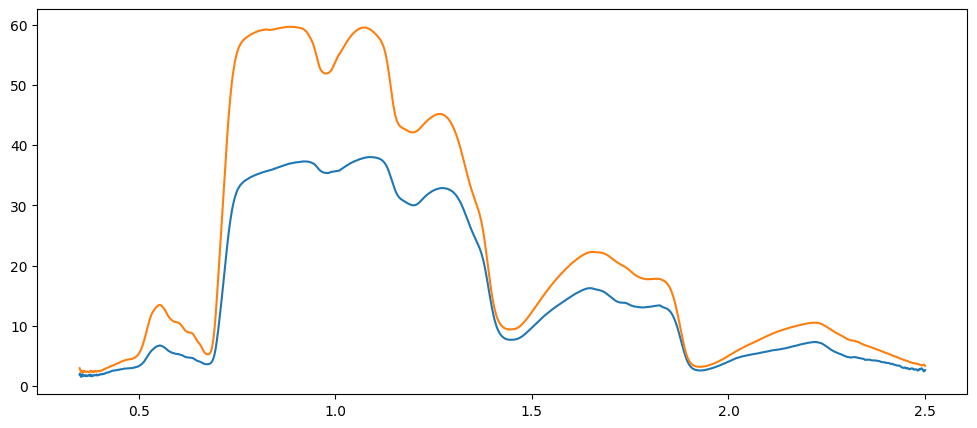

In [5]:
plt.plot(wl_asd, X1[15,:])
plt.plot(wl_asd, X1[5,:])

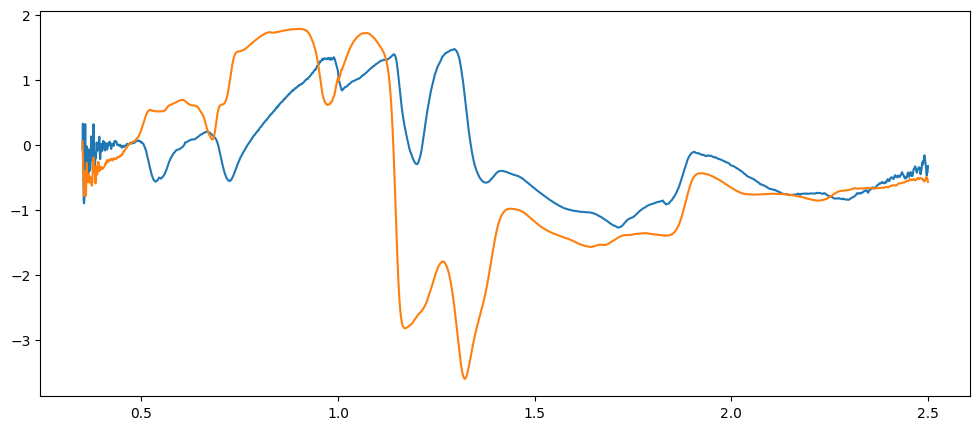

In [6]:
plt.plot(wl_asd, X1n[15,:])
plt.plot(wl_asd, X1n[5,:])

## Exploring the relationship between NDVI and water content

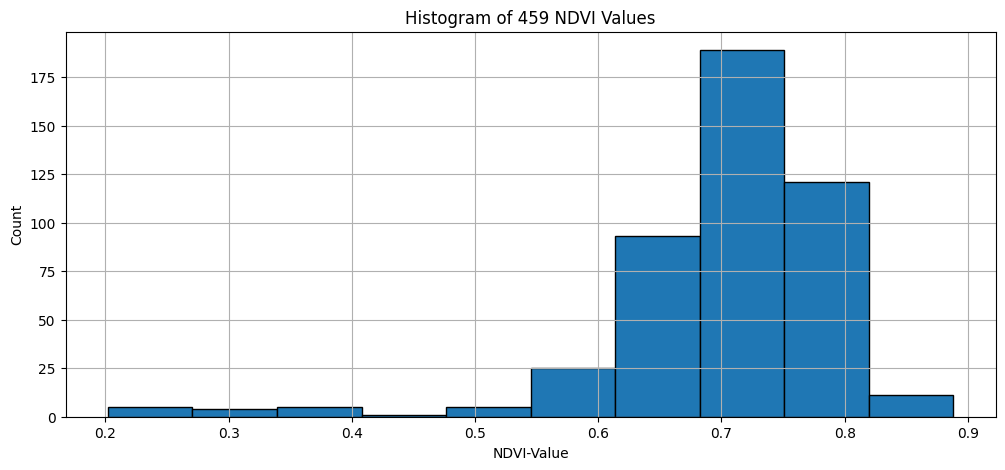

In [7]:
ndvi_list = []
for j in range(X['asd']['w'].shape[0]):
    ir = X['asd']['w'][j,400]
    red = X['asd']['w'][j,300]
    ndvi = (ir - red) / (ir  + red)
    ndvi_list.append(ndvi)
ndvi = np.asarray(ndvi_list)

plt.hist(ndvi);
plt.title('Histogram of '+str(len(ndvi_list))+' NDVI Values');
plt.xlabel('NDVI-Value');
plt.ylabel('Count');
plt.grid(True);

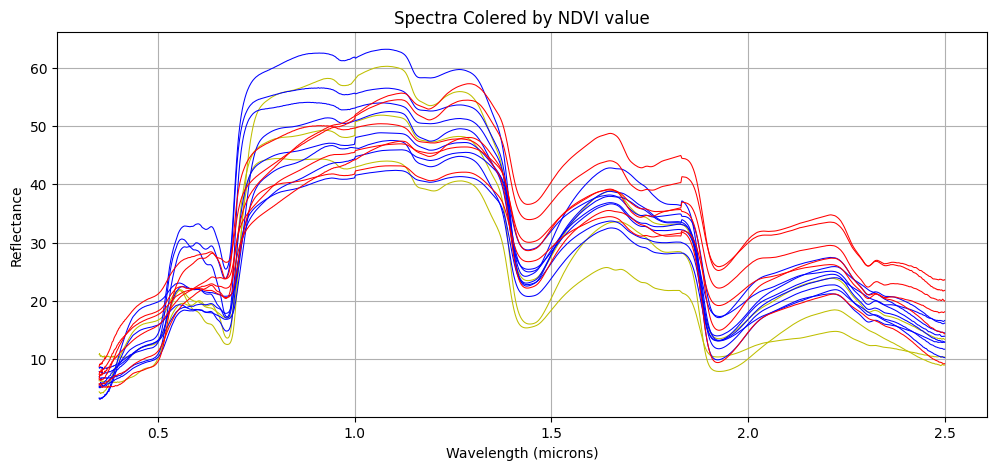

In [8]:
for i in np.where(ndvi>0.95)[0]:
    plt.plot(wl_asd, X['asd']['w'][i,:], c='g', linewidth=0.25)
for i in np.where( np.logical_and(ndvi<0.5, ndvi>0.4) )[0]:
    plt.plot(wl_asd, X['asd']['w'][i,:], c='y', linewidth=0.75)
for i in np.where( np.logical_and(ndvi<0.4, ndvi>0.3) )[0]:
    plt.plot(wl_asd, X['asd']['w'][i,:], c='b', linewidth=0.75)
for i in np.where( ndvi<0.3 )[0]:
    plt.plot(wl_asd, X['asd']['w'][i,:], c='r', linewidth=0.75)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Reflectance')
plt.grid(True)
plt.title('Spectra Colered by NDVI value');

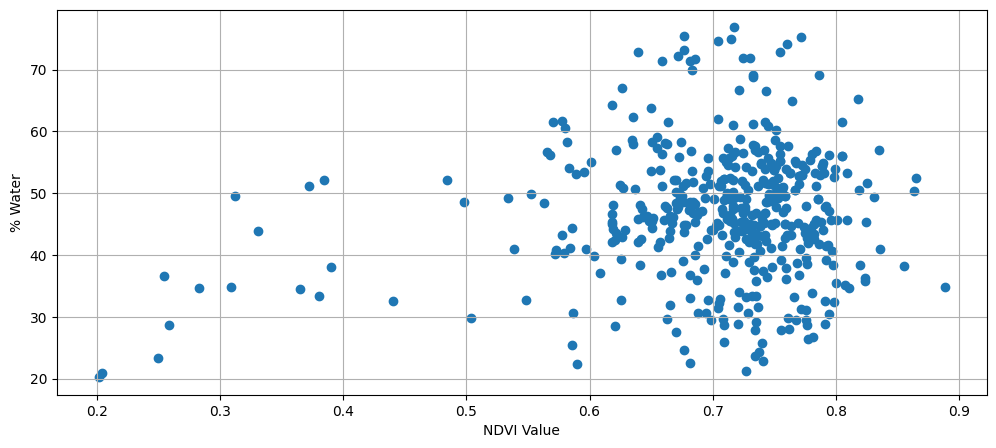

In [9]:
plt.scatter(ndvi,y['asd']['w']);
plt.xlabel('NDVI Value')
plt.ylabel('% Water')
plt.grid(True)

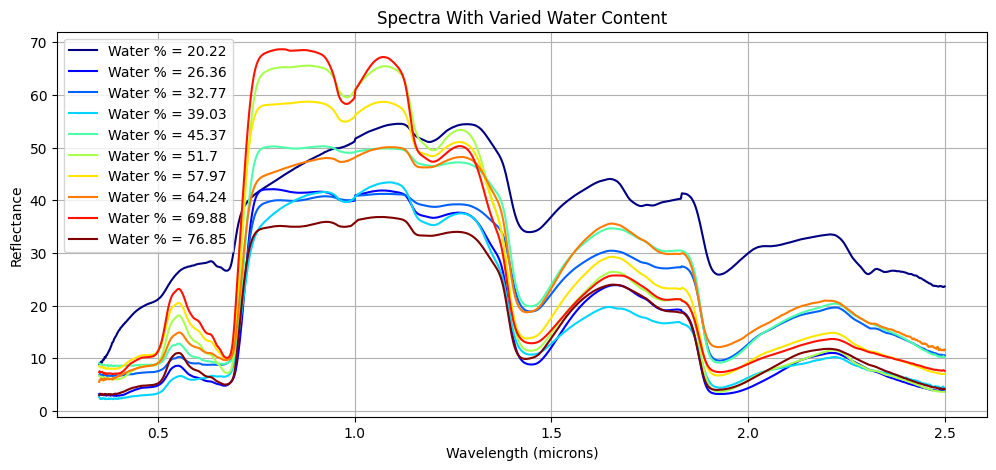

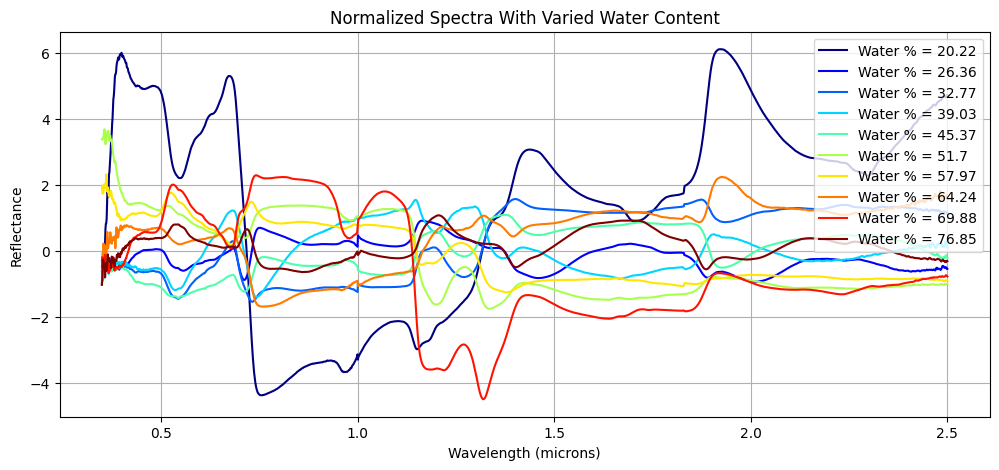

In [10]:
# plot n spectra with a variation in water content

# get the indices for n evenly space % water content values
n = 10
min_water = np.min(y['asd']['w'])
max_water = np.max(y['asd']['w'])
selected_water = np.linspace(min_water, max_water, num=n)
idx = []
for water in selected_water:
    idx.append(np.argmin(np.abs( y['asd']['w']-water)))

colors = plt.cm.jet(np.linspace(0,1,n))

plt.figure()
for i in range(len(idx)):
    # This if statement skips spectra that are a duplicate of the previous spectra
    if idx[i] != idx[i-1]:
        s = X['asd']['w'][idx[i],:]
        pct = y['asd']['w'][idx[i]]
        c = colors[i]
        plt.plot(wl_asd, s, label=f'Water % = {pct}', c=c)
plt.legend();
plt.xlabel('Wavelength (microns)')
plt.ylabel('Reflectance')
plt.grid(True)
plt.title('Spectra With Varied Water Content');

plt.figure()
for i in range(len(idx)):
    # This if statement skips spectra that are a duplicate of the previous spectra
    if idx[i] != idx[i-1]:
        s = Xn['asd']['w'][idx[i],:]
        pct = y['asd']['w'][idx[i]]
        c = colors[i]
        plt.plot(wl_asd, s, label=f'Water % = {pct}', c=c)
plt.legend();
plt.xlabel('Wavelength (microns)')
plt.ylabel('Reflectance')
plt.grid(True)
plt.title('Normalized Spectra With Varied Water Content');

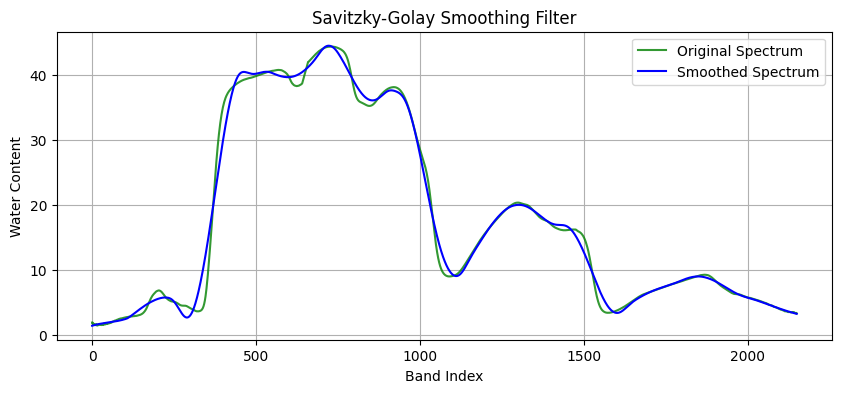

In [11]:
### Savitzky-Golay smoothing filter ###
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

num_samples = len(X['asd']['w'])
num_bands = len(X['asd']['w'][0])

# Apply Savitzky-Golay smoothing filter to each spectrum
smoothed_X = np.zeros_like(X['asd']['w'])
window_length = 215  # 2151 bands divided by 10
polyorder = 3      # Adjust as needed
for i in range(num_samples):
    smoothed_X[i] = savgol_filter(X['asd']['w'][i], window_length=window_length, polyorder=polyorder)
# Plot original and smoothed spectra
plt.figure(figsize=(10, 4))
plt.plot(np.arange(num_bands), X['asd']['w'][0], label='Original Spectrum', color='green', alpha=0.8)
plt.plot(np.arange(num_bands), smoothed_X[0], label='Smoothed Spectrum', color='blue')
plt.xlabel('Band Index')
plt.ylabel('Water Content')
plt.title('Savitzky-Golay Smoothing Filter')
plt.legend()
plt.grid(True)
plt.show()


# Evaluating regression models for all sensors and constituents

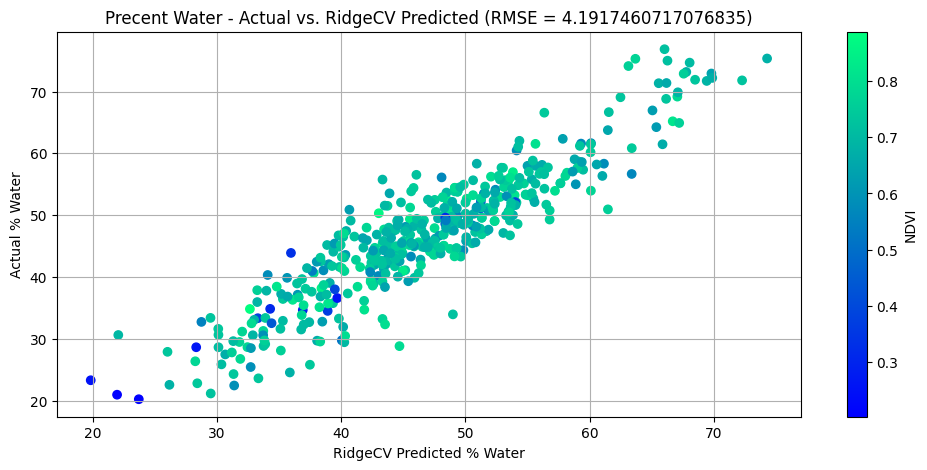

In [12]:
# Using full data for training and testing

s = 'asd' #['asd', 'nic']
c = 'w' #['w','n','c']
y1 = y[s][c]
X1 = X[s][c]
names = name[s][c]

reg1 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X1, y1)
preds = reg1.predict(X1)
rmse = np.sqrt(np.mean((preds-y1)**2))

plt.scatter(preds, y1, c=ndvi, cmap = plt.get_cmap('winter'))
plt.colorbar(label='NDVI')
plt.grid(True)
plt.xlabel('RidgeCV Predicted % Water')
plt.ylabel('Actual % Water')
plt.title(f'Precent Water - Actual vs. RidgeCV Predicted (RMSE = {rmse})');

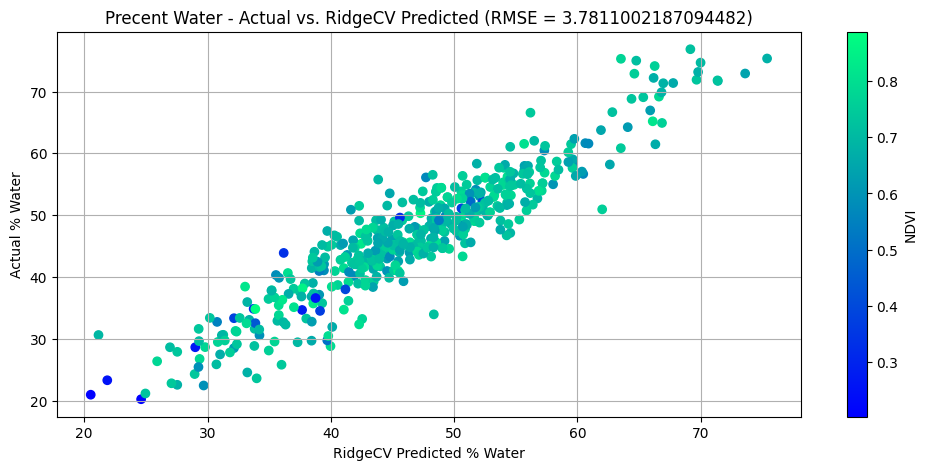

In [13]:
# Using full normalized data for training and testing

# s = 'asd' #['asd', 'nic']
c = 'w' #['w','n','c']        
y1 = y[s][c]
X1 = Xn[s][c]
names = name[s][c]

reg1 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X1, y1)
preds = reg1.predict(X1)
rmse = np.sqrt(np.mean((preds-y1)**2))

plt.scatter(preds, y1, c=ndvi, cmap = plt.get_cmap('winter'))
plt.colorbar(label='NDVI')
plt.grid(True)
plt.xlabel('RidgeCV Predicted % Water')
plt.ylabel('Actual % Water')
plt.title(f'Precent Water - Actual vs. RidgeCV Predicted (RMSE = {rmse})');

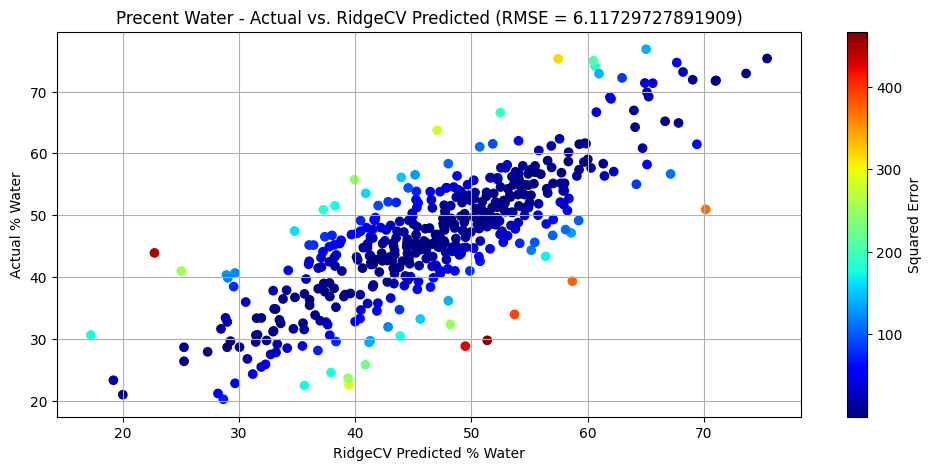

In [14]:
# Using normalized data with cross validation

s = 'asd' #['asd', 'nic']
c = 'w' #['w','n','c']        
y1 = y[s][c]
X1 = Xn[s][c]
names = name[s][c]

reg1 = RidgeCV(alphas=[0.001, 0.01, 0.1, 0.5, 1])
kf = KFold(n_splits=100, shuffle=True)
#cv_rmse_scores = np.sqrt((-1)*(np.asarray(cross_val_score(reg1, X1, y1, cv=kf, scoring='neg_mean_squared_error'))))
#print(cv_rmse_scores, np.mean(cv_rmse_scores))

cv_preds = sklearn.model_selection.cross_val_predict(reg1, X1, y1, cv=kf)
sq_error = (cv_preds-y1)**2
rmse = np.sqrt(np.mean(sq_error))

plt.scatter(cv_preds, y1, c=sq_error, cmap = plt.get_cmap('jet'))
plt.colorbar(label='Squared Error')
plt.grid(True)
plt.xlabel('RidgeCV Predicted % Water')
plt.ylabel('Actual % Water')
plt.title(f'Precent Water - Actual vs. RidgeCV Predicted (RMSE = {rmse})');

# Evaluate Spectra with Highest Error

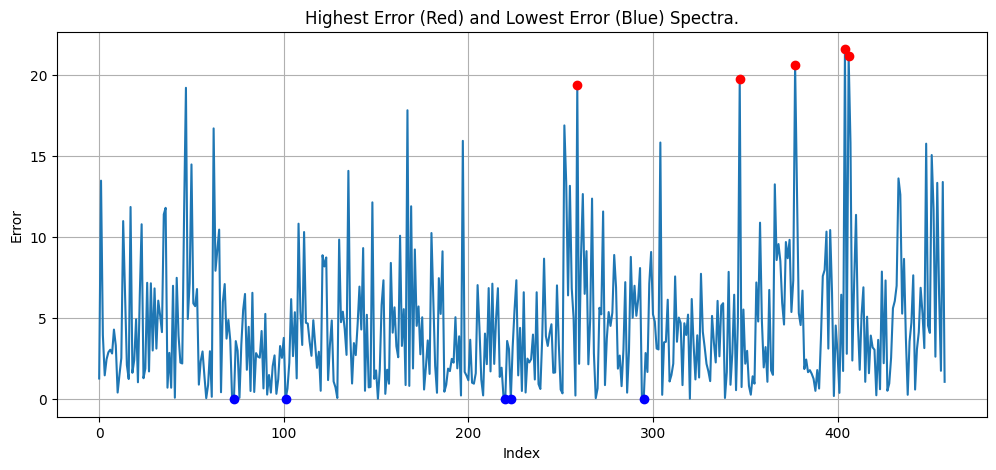

In [15]:
error = np.abs(cv_preds-y1)
plt.plot(error)

n = len(error)
idx_sort = np.argsort(error)
lowest_error_index = idx_sort[0:5]
highest_error_index = idx_sort[n-5:n]
for i in lowest_error_index:
    plt.plot(i,error[i], c='b', marker='o')
for i in highest_error_index:
    plt.plot(i,error[i], c='r', marker='o')
plt.ylabel('Error')
plt.xlabel('Index')
plt.grid(True)
plt.title('Highest Error (Red) and Lowest Error (Blue) Spectra.');

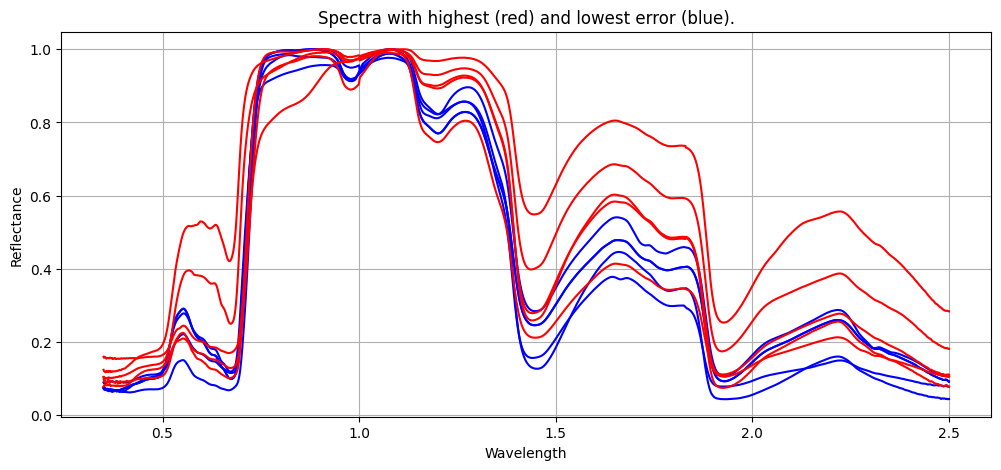

In [16]:
s = 'asd' #['asd', 'nic']
c = 'w' #['w','n','c']        
y1 = y[s][c]
X1 = X[s][c]
names = name[s][c]

plt.figure()
for i in lowest_error_index:
    plt.plot(wl_asd, X1[i,:]/np.max(X1[i,:]), c='b')
for i in highest_error_index:
    plt.plot(wl_asd, X1[i,:]/np.max(X1[i,:]), c='r')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.grid(True)
plt.title('Spectra with highest (red) and lowest error (blue).');

# Create a plot for each species, with spectra colored by water content

In [17]:
s = 'asd' #['asd', 'nic']
c = 'w' #['w','n','c']        
y1 = y[s][c]
X1 = X[s][c]
names = name[s][c]
species = []

def find_nth(string, substring, n):
   if (n == 1):
       return string.find(substring)
   else:
       return string.find(substring, find_nth(string, substring, n - 1) + 1)

for i in range(len(names)):
    n = names[i]
    n = n.replace('vegetation.','')
    idx = find_nth(n,'.',3)
    n = n[0:idx]
    species.append(n)
species = np.asarray(species)
unique_species = np.unique(species)

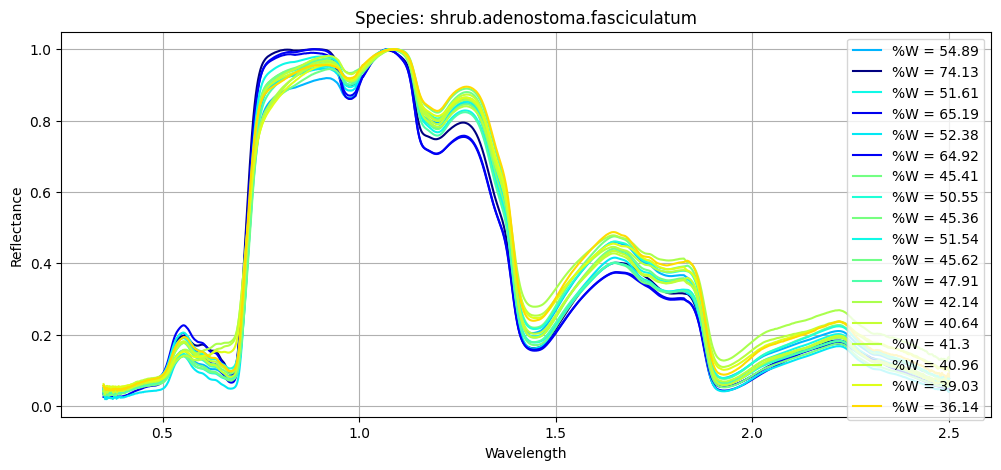

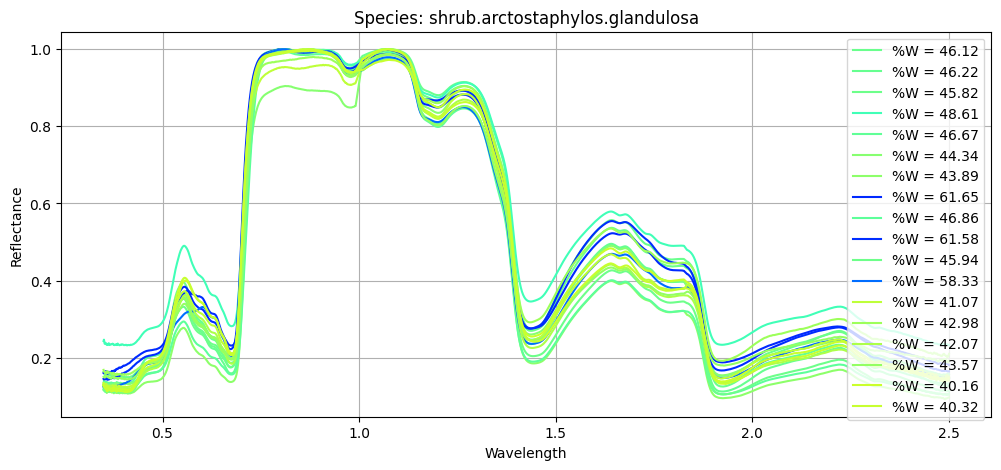

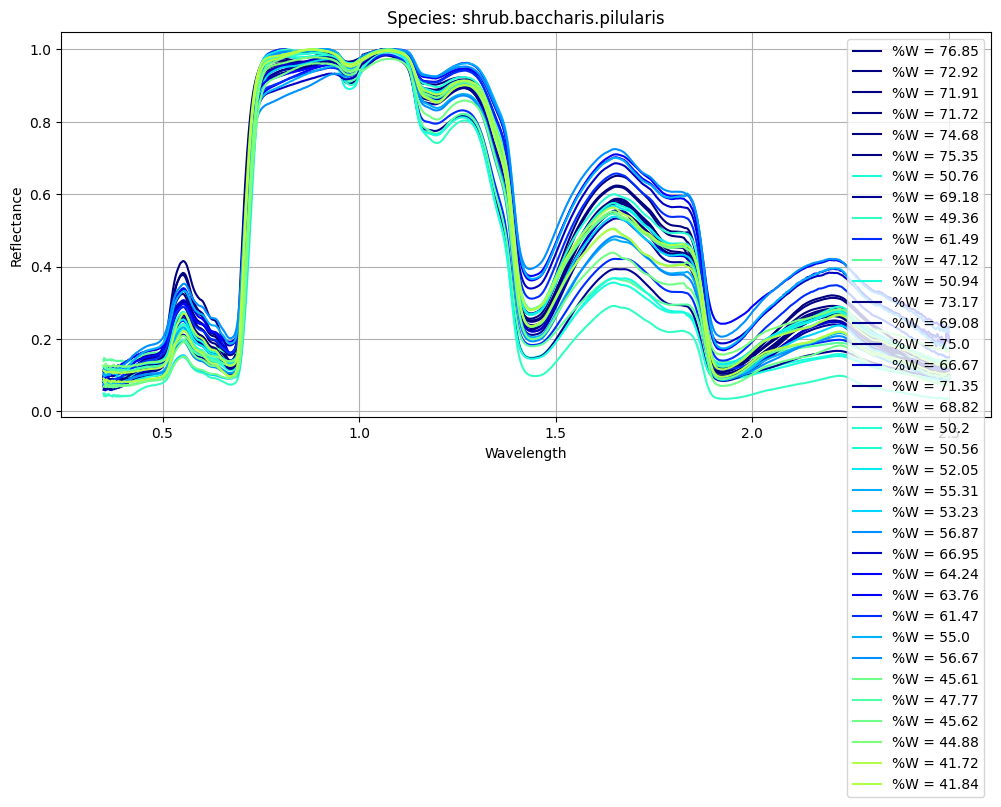

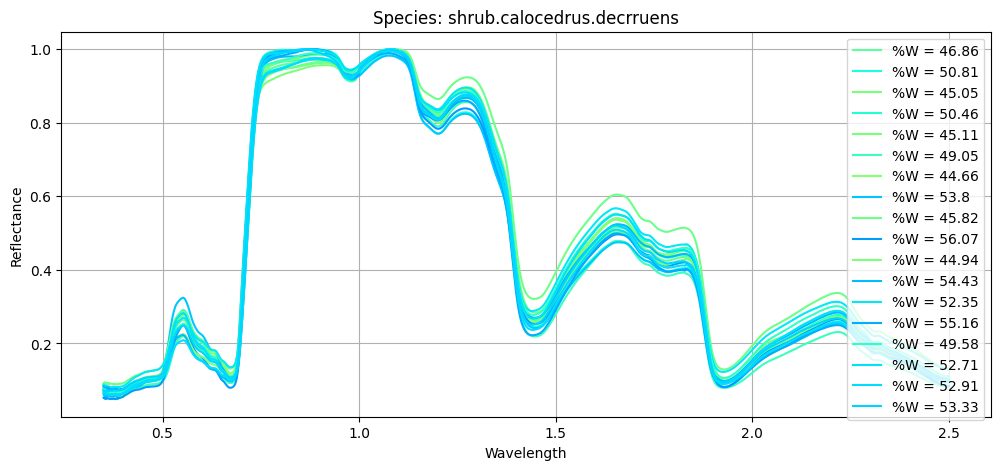

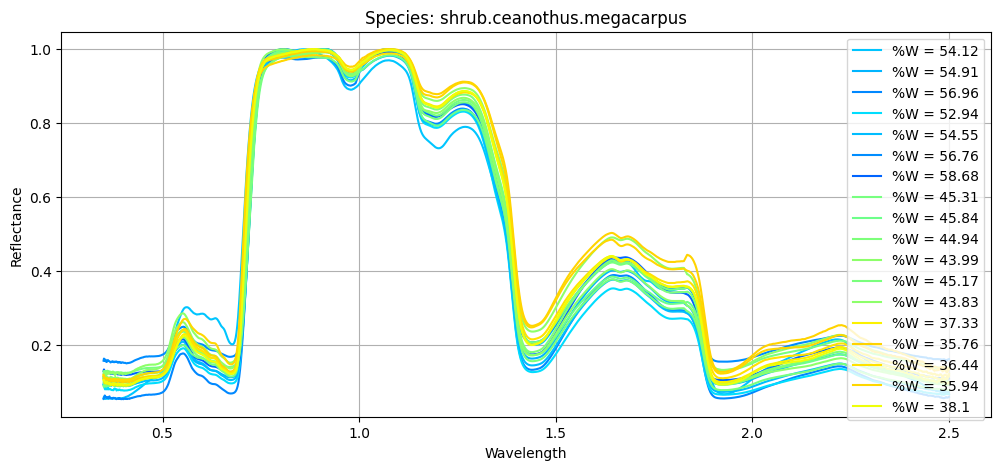

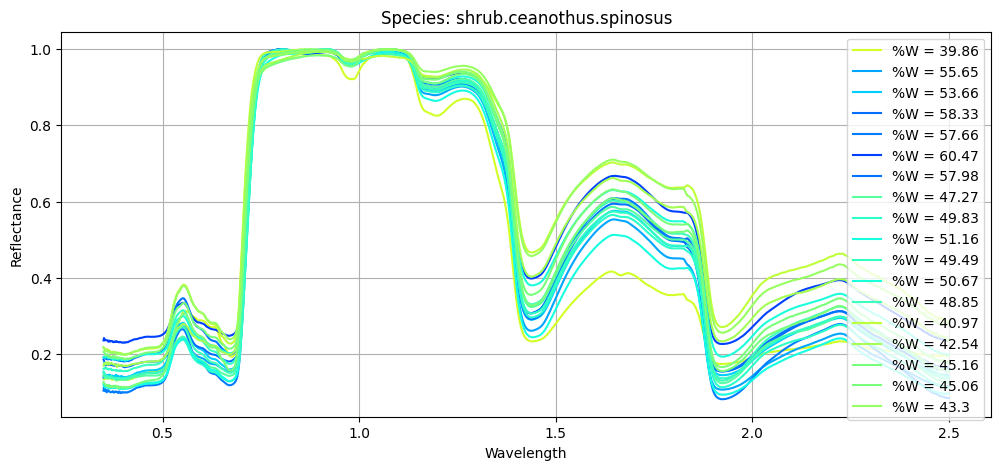

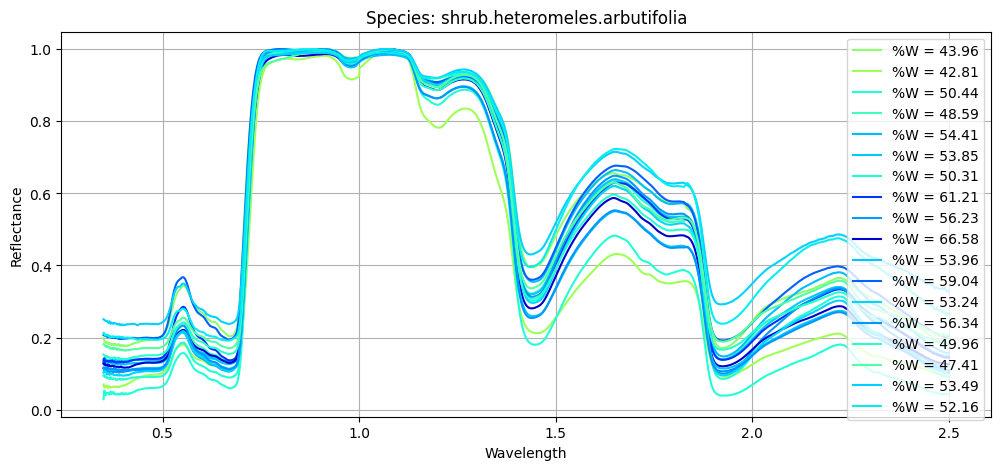

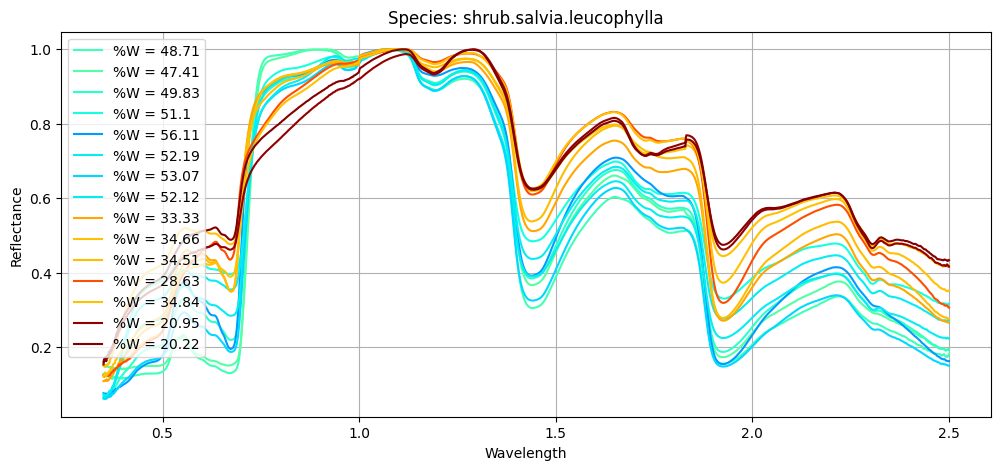

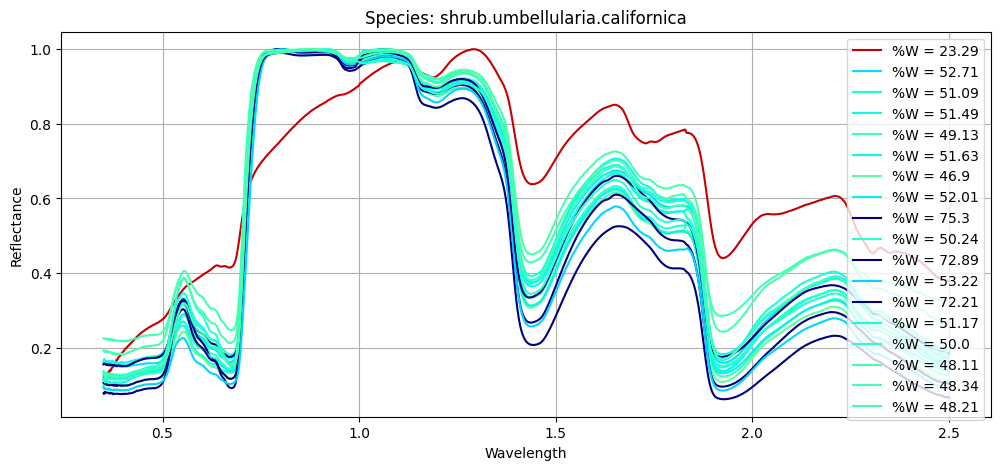

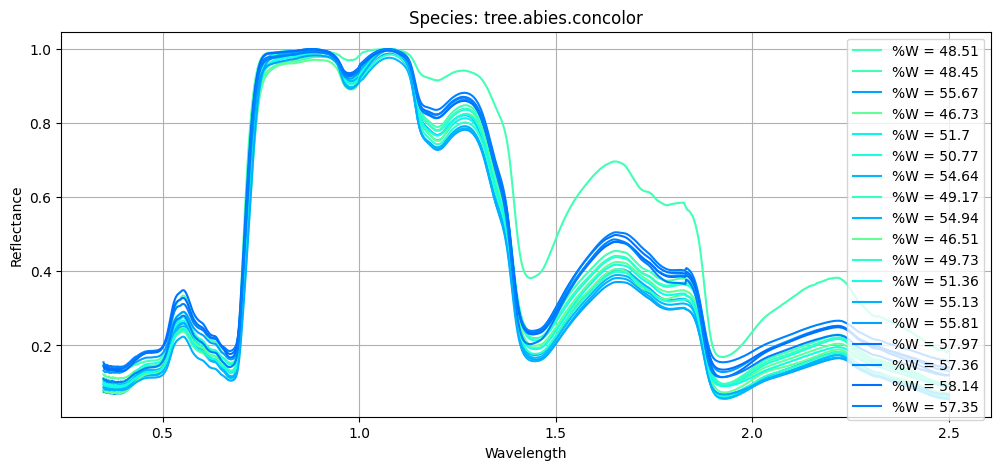

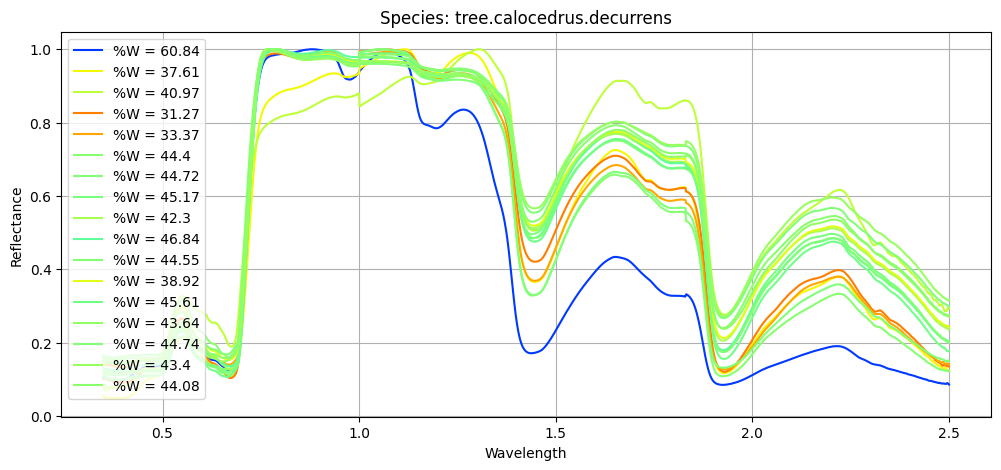

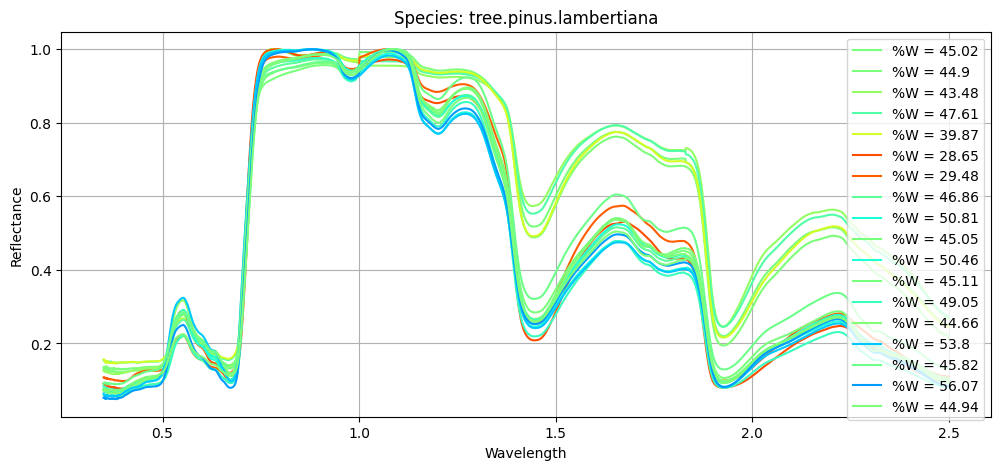

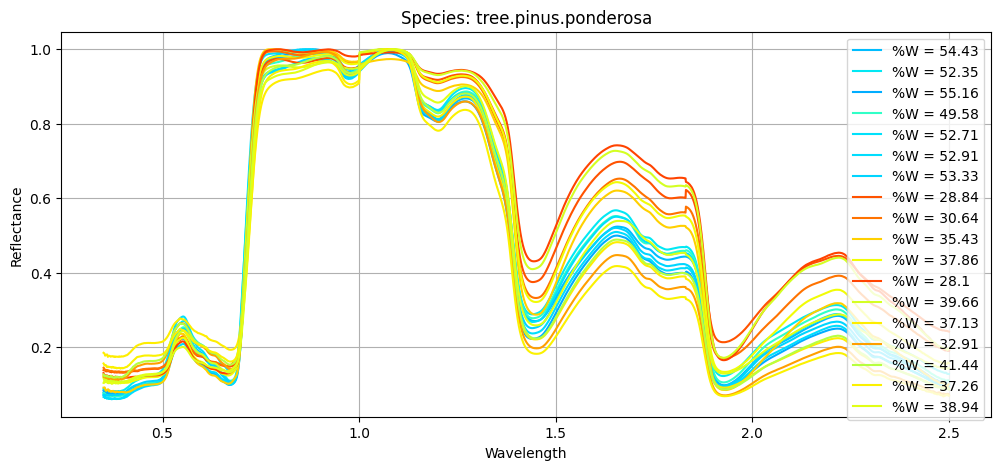

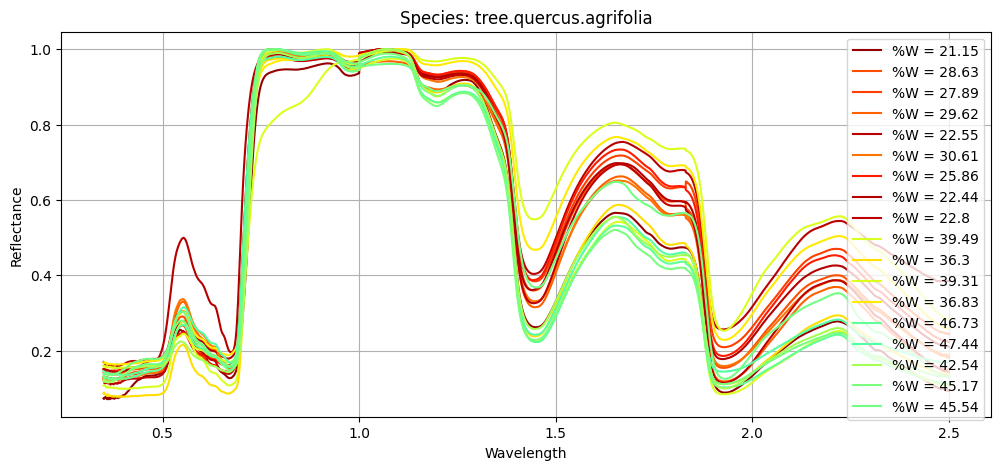

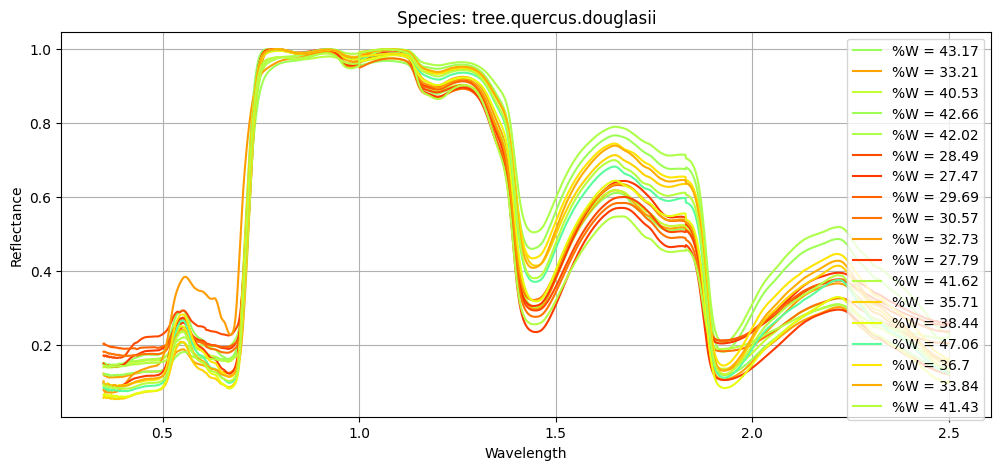

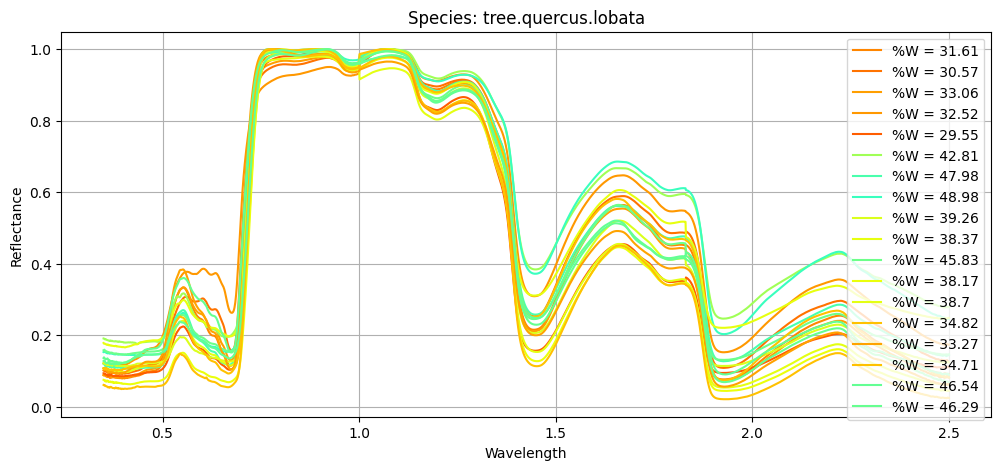

In [18]:
for s in unique_species:
    plt.figure()
    plt.set_cmap("gist_rainbow") 
    plt.title('Species: '+s)
    idx = np.where(species==s)[0]
    for i in idx:
        spec = X1[i,:]
        pct = y1[i]
        c = plt.cm.jet(1-np.clip(2*(pct-20)/100, 0, 1))
        plt.plot(wl_asd, spec/np.max(spec), label=f'%W = {pct}', c=c)
    plt.grid(True)
    plt.legend()
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance');
    

# Lazypredictions

In [19]:
# Run lazypredict for all sensors and all chemistry (non-normalized spectra)
for s in ['asd', 'nic']:
    for c in ['w','n','c']:
        # create a test-train split for this data
        X_train, X_test, y_train, y_test = train_test_split(X[s][c], y[s][c],test_size=0.2,random_state = 42)
        reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
        
        # compute the models, predictions, and metrics
        models, predictions = reg.fit(X_train, X_test, y_train, y_test)
        
        # save to a csv 
        models.to_csv('results'+s+'_'+c+'.csv')

  0%|          | 0/42 [00:00<?, ?it/s]

 40%|████      | 17/42 [02:41<01:56,  4.65s/it]

Lars model failed to execute
Input contains NaN.


 43%|████▎     | 18/42 [02:42<01:31,  3.83s/it]

LarsCV model failed to execute
cannot convert float NaN to integer


 45%|████▌     | 19/42 [02:43<01:03,  2.77s/it]

In [ ]:
# Run lazypredict for all sensors and all chemistry (normalized spectra)
for s in ['asd', 'nic']:
    for c in ['w','n','c']:
        # create a test-train split for this data
        X_train, X_test, y_train, y_test = train_test_split(Xn[s][c], y[s][c],test_size=0.2,random_state = 42)
        reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
        
        # compute the models, predictions, and metrics
        models, predictions = reg.fit(X_train, X_test, y_train, y_test)
        
        # save to a csv 
        models.to_csv('results'+s+'_'+c+'_normalized.csv')

  0%|          | 0/42 [00:00<?, ?it/s]

 57%|█████▋    | 24/42 [03:25<02:20,  7.80s/it]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 76%|███████▌  | 32/42 [03:34<00:13,  1.30s/it]

RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 367.


 98%|█████████▊| 41/42 [04:24<00:03,  3.59s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264188
[LightGBM] [Info] Number of data points in the train set: 367, number of used features: 2151
[LightGBM] [Info] Start training from score 47.193215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

100%|██████████| 42/42 [04:26<00:00,  6.34s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


# Evaluating Predictions

# FROM BILL - I CLEANED UP CODE ABOVE THIS LOCATION

In [ ]:
# Run lazypredict for water content with 5-fold cross validation ???  NOT RUNNING

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import numpy as np

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LazyRegressor object with 5-fold cross-validation
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None, predictions=True)

# Fit LazyRegressor on the training data
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Fit LazyRegressor using cross-validation
cv_scores = cross_val_score(reg, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the summary of model performance
print(cv_scores)
print(models)

KeyError: 0

Root Mean Squared Error: 7.910178368467881


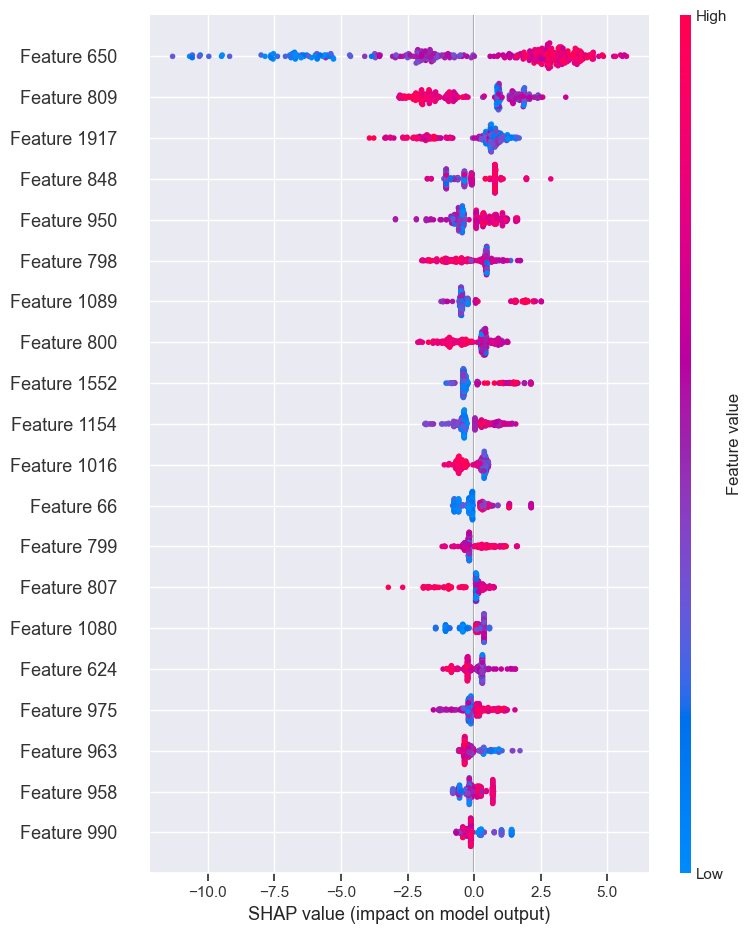

In [ ]:
### XGB USING TEST-TRAIN SPLIT ###

import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model to training data
xgb_reg.fit(X_train, y_train)

# Predict on the testing data
y_pred = xgb_reg.predict(X_test)

# Create explainer object
explainer = shap.Explainer(xgb_reg, X_train)

# Compute Shapley values
shap_values = explainer.shap_values(X_train)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
xgb_rmse = np.sqrt(mse)
print("Root Mean Squared Error:", xgb_rmse)

# Shapley summary plot
shap.summary_plot(shap_values, X_train)

In [ ]:
### GET PERMUTATION IMPORTANCE for XGB WITH TEST-TRAIN SPLIT ###

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model to training data
xgb_reg.fit(X_train, y_train)

# Calculate permutation importance
perm_impt = permutation_importance(xgb_reg, X_test, y_test, random_state=42, n_repeats=10, n_jobs=-1)

# Get feature importances
perm_importances = perm_impt.importances_mean

# Get indices of features sorted by importance
sorted_indices_perm_impt = perm_importances.argsort()[::-1]

# Print feature importances
for idx in sorted_indices_perm_impt:
    print(f"Feature {idx}: {perm_importances[idx]}")

Feature 650: 0.19083636126769604
Feature 809: 0.11704298393993469
Feature 848: 0.05268303054933998
Feature 66: 0.04904689255632292
Feature 807: 0.04178549657918311
Feature 950: 0.03296567689406259
Feature 1531: 0.02735779282837949
Feature 84: 0.025626826136582116
Feature 805: 0.022566984015072476
Feature 1023: 0.01974573444278078
Feature 1577: 0.017575065619269626
Feature 958: 0.01683056074048802
Feature 1024: 0.0154380701985263
Feature 798: 0.015206032569655071
Feature 1154: 0.014267168680176811
Feature 1537: 0.013305345776513022
Feature 804: 0.01267506404830493
Feature 41: 0.012647670676427835
Feature 1016: 0.01232934565716549
Feature 797: 0.011917771214296168
Feature 1057: 0.01158056627174714
Feature 455: 0.011225478486931274
Feature 800: 0.011087292934512072
Feature 201: 0.010705370673070081
Feature 963: 0.010544531280808456
Feature 3: 0.009973802847601443
Feature 794: 0.009486141692646898
Feature 1532: 0.0075720642023661576
Feature 56: 0.007551877198362755
Feature 2140: 0.00753853

Mean squared error for each fold: [57.56884815 50.23179879 53.40039868 65.82992841 43.78977355]
Average Mean squared error across all folds: 54.164149515615534
RMSE across all folds: 7.359629713213534


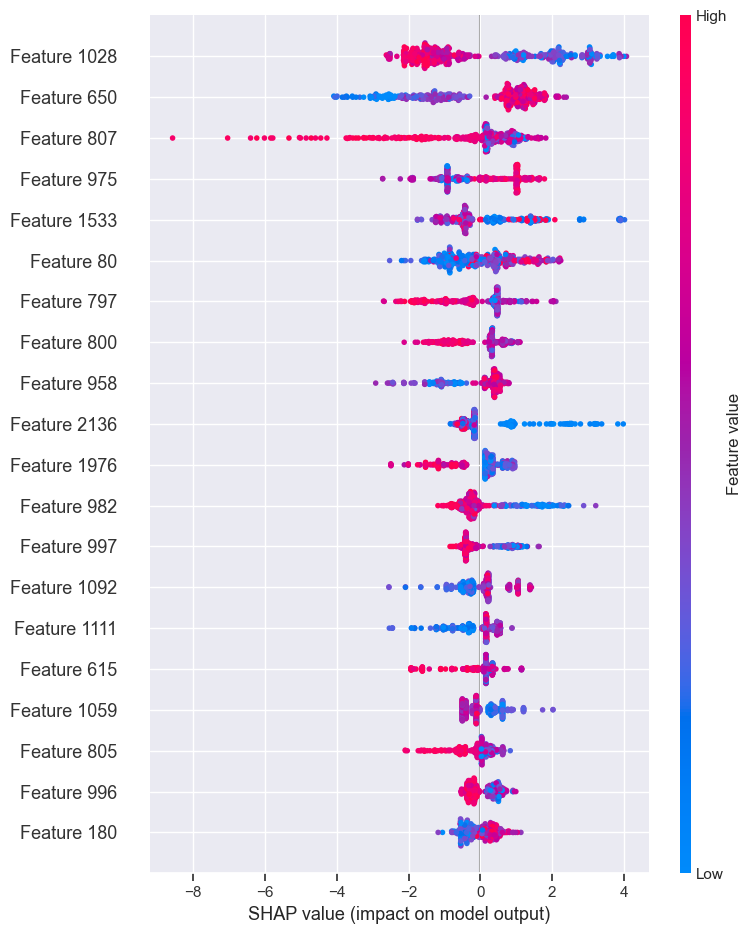

In [ ]:
### XGB WITH 5-FOLD CROSS VALIDATION AND SHAPLEY USING ALL DATA ###
### NDVI < 0.5 ###

import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

reg_name= 'XGBoost with 5CV'

# Initialize XGBRegressor
xgb_reg_5cv = xgb.XGBRegressor(objective='reg:squarederror')

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
xgb_cv_scores = cross_val_score(xgb_reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Fit the model to all data
xgb_reg_5cv.fit(X,y)

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -xgb_cv_scores)
print("Average Mean squared error across all folds:", -np.mean(xgb_cv_scores))
print('RMSE across all folds:',np.sqrt(-np.mean(xgb_cv_scores)))

# Create explainer object
explainer_5cv = shap.Explainer(xgb_reg_5cv, X)

# Compute Shapley values
shap_values_5cv = explainer_5cv.shap_values(X)

# Shapley summary plot
shap.summary_plot(shap_values_5cv, X)

Mean squared error for each fold: [55.94606009 49.90933125 53.96707991 59.5936477  97.55950253]
Average Mean squared error across all folds: 63.395124296824235
RMSE across all folds: 7.962105519071211


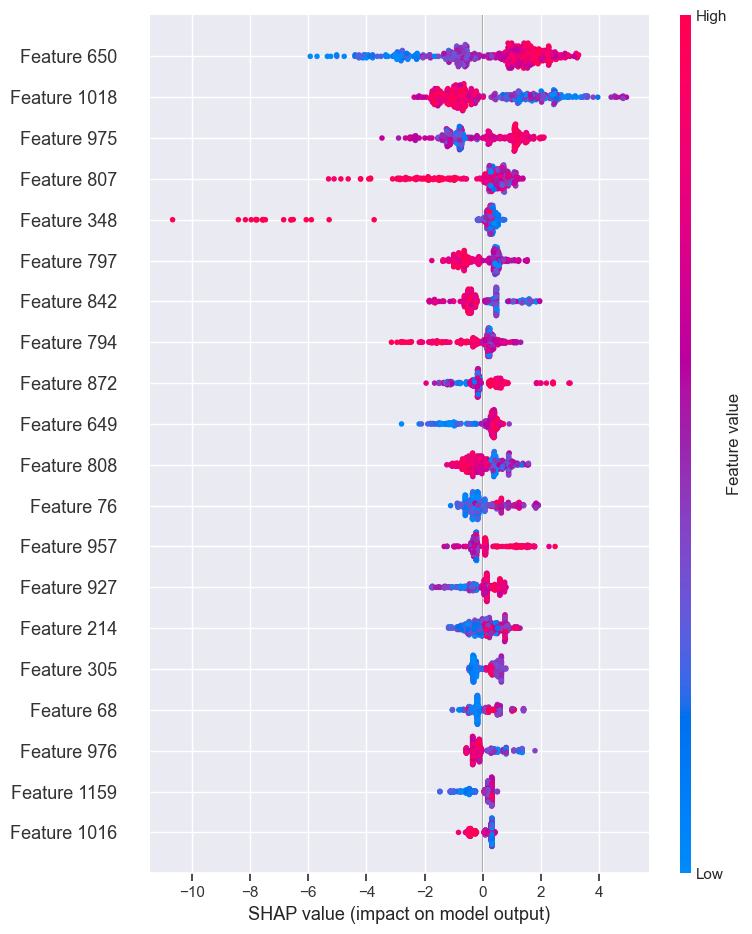

In [ ]:
### XGB WITH 5-FOLD CROSS VALIDATION AND SHAPLEY USING ALL DATA ###
### No NDVI Exclusions ###

import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

reg_name= 'XGBoost with 5CV'

# Initialize XGBRegressor
xgb_reg_5cv = xgb.XGBRegressor(objective='reg:squarederror')

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
xgb_cv_scores = cross_val_score(xgb_reg_5cv, X2, y1, cv=kf, scoring='neg_mean_squared_error')

# Fit the model to all data
xgb_reg_5cv.fit(X2,y1)

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -xgb_cv_scores)
print("Average Mean squared error across all folds:", -np.mean(xgb_cv_scores))
print('RMSE across all folds:',np.sqrt(-np.mean(xgb_cv_scores)))

# Create explainer object
explainer_5cv = shap.Explainer(xgb_reg_5cv, X2)

# Compute Shapley values
shap_values_5cv = explainer_5cv.shap_values(X2)

# Shapley summary plot
shap.summary_plot(shap_values_5cv, X2)

In [ ]:
### GET PERMUTATION IMPORTANCE for XGB WITH 5-FOLD CROSS VALIDATION ###

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
xgb_cv_scores = cross_val_score(xgb_reg, X, y, cv=kf, scoring='neg_mean_squared_error')

# Fit the model to all data
xgb_reg.fit(X,y)

# Calculate permutation importance
# perm_impt = permutation_importance(xgb_reg, X_test, y_test, random_state=42, n_repeats=10, n_jobs=-1)
perm_impt = permutation_importance(xgb_reg, X, y, n_repeats=10, n_jobs=-1)

# Get feature importances
perm_importances = perm_impt.importances_mean

# Get indices of features sorted by importance
sorted_indices_perm_impt = perm_importances.argsort()[::-1]

# Print feature importances
for idx in sorted_indices_perm_impt:
    print(f"Feature {idx}: {perm_importances[idx]}")

# Print mean cross-validation score
print("Mean MSE:", -np.mean(xgb_cv_scores))

Feature 1018: 0.06429838828357133
Feature 650: 0.06322349299459881
Feature 960: 0.05137511074618588
Feature 807: 0.042351308718378375
Feature 1644: 0.034184988886763246
Feature 983: 0.02922092950250338
Feature 180: 0.028847663486916496
Feature 1912: 0.028392766941351587
Feature 2150: 0.02759843715175081
Feature 965: 0.0275949910550237
Feature 1031: 0.024907850256291886
Feature 1650: 0.023686790946576764
Feature 1526: 0.020503756698793073
Feature 72: 0.01923435590103507
Feature 1161: 0.018409159611763835
Feature 877: 0.01809546168434758
Feature 1016: 0.015804899958716777
Feature 806: 0.01371544406605174
Feature 0: 0.01353710624728035
Feature 1541: 0.012685216843890835
Feature 817: 0.011485104432497839
Feature 961: 0.01144899460442167
Feature 835: 0.011399483402892397
Feature 1913: 0.01051811973847091
Feature 801: 0.010497824428048553
Feature 90: 0.008787777627382708
Feature 971: 0.008354789058331846
Feature 956: 0.008266268601841376
Feature 799: 0.008020454251804966
Feature 651: 0.00684

In [ ]:
### GET PERMUTATION IMPORTANCE for XGB WITH 5-FOLD CROSS VALIDATION ###

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
xgb_cv_scores = cross_val_score(xgb_reg, X, y, cv=kf, scoring='neg_mean_squared_error')

# Fit the model to all data
xgb_reg.fit(X,y)

# Calculate permutation importance
# perm_impt = permutation_importance(xgb_reg, X_test, y_test, random_state=42, n_repeats=10, n_jobs=-1)
perm_impt = permutation_importance(xgb_reg, X, y, n_repeats=10, n_jobs=-1)

# Get feature importances
perm_importances = perm_impt.importances_mean

# Get indices of features sorted by importance
sorted_indices_perm_impt = perm_importances.argsort()[::-1]

# Print feature importances
for idx in sorted_indices_perm_impt:
    print(f"Feature {idx}: {perm_importances[idx]}")

# Print mean cross-validation score
print("Mean MSE:", -np.mean(xgb_cv_scores))

Feature 1018: 0.06429838828357133
Feature 650: 0.06322349299459881
Feature 960: 0.05137511074618588
Feature 807: 0.042351308718378375
Feature 1644: 0.034184988886763246
Feature 983: 0.02922092950250338
Feature 180: 0.028847663486916496
Feature 1912: 0.028392766941351587
Feature 2150: 0.02759843715175081
Feature 965: 0.0275949910550237
Feature 1031: 0.024907850256291886
Feature 1650: 0.023686790946576764
Feature 1526: 0.020503756698793073
Feature 72: 0.01923435590103507
Feature 1161: 0.018409159611763835
Feature 877: 0.01809546168434758
Feature 1016: 0.015804899958716777
Feature 806: 0.01371544406605174
Feature 0: 0.01353710624728035
Feature 1541: 0.012685216843890835
Feature 817: 0.011485104432497839
Feature 961: 0.01144899460442167
Feature 835: 0.011399483402892397
Feature 1913: 0.01051811973847091
Feature 801: 0.010497824428048553
Feature 90: 0.008787777627382708
Feature 971: 0.008354789058331846
Feature 956: 0.008266268601841376
Feature 799: 0.008020454251804966
Feature 651: 0.00684

Mean squared error on test set: 4.95640247742602e-06
Root Mean Squared Error on Test Set: 0.0022262979309665676
R-squared on Test Set: 0.9999999564629569
          Regressor       MSE      RMSE  R-Squared
0  XGBoost with 5CV  0.000005  0.002226        1.0


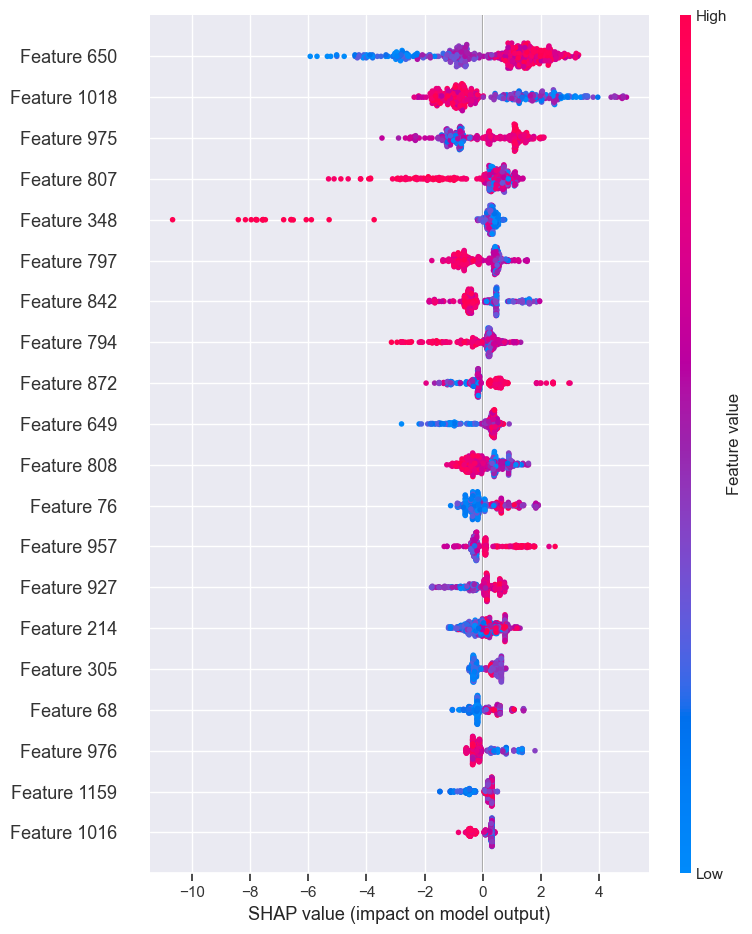

In [ ]:
### Don't worry about this for abstract ###

xgb_reg_5cv.fit(X,y)
    
# Predict on the testing data
y_pred_5cv = xgb_reg_5cv.predict(X)

# Calculate and print the mean squared error on the test set
xgb_mse_test_5cv = mean_squared_error(y, y_pred_5cv)
xgb_rmse_test_5cv = np.sqrt(xgb_mse_test_5cv)
print("Mean squared error on test set:", xgb_mse_test_5cv)
print("Root Mean Squared Error on Test Set:", xgb_rmse_test_5cv)
r_sq_test = r2_score(y, y_pred_5cv)
print("R-squared on Test Set:", r_sq_test)

# Create a new DataFrame to store the results
results_df_xgb = pd.DataFrame({'Regressor': [reg_name],
    'MSE': [xgb_mse_test_5cv],
    'RMSE': [xgb_rmse_test_5cv],
    'R-Squared': [r_sq_test]})

print(results_df_xgb)

# Create explainer object
explainer_5cv = shap.Explainer(xgb_reg_5cv, X)

# Compute Shapley values
shap_values_5cv = explainer_5cv.shap_values(X)

# Shapley summary plot
shap.summary_plot(shap_values_5cv, X)

In [ ]:
### RIDGE WITH 5-FOLD CROSS VALIDATION ###

from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define the Ridge Regression model
ridge_model = Ridge()

# Fit the model on the whole training set
ridge_model.fit(X, y)

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(ridge_model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -cv_scores)
print("Mean squared error across all folds:", -np.mean(cv_scores))

# Predict on the test set
y_pred = ridge_model.predict(X)

# Calculate and print the mean squared error on the test set
mse_test = mean_squared_error(y, y_pred)
rmse_test = np.sqrt(mse_test)
print("Mean squared error on test set:", mse_test)
print("Root Mean Squared Error on Test Set:", rmse_test)


Mean squared error for each fold: [108.46071267  73.73729338 121.04276018  98.17491524 118.24149817]
Mean squared error across all folds: 103.93143592828501
Mean squared error on test set: 102.0062462190588
Root Mean Squared Error on Test Set: 10.099814167550747


In [ ]:
### RIDGE WITH 5-FOLD CROSS VALIDATION ON Savitzky-Golay smoothed X ###

from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define the Ridge Regression model
ridge_model = Ridge()

# Fit the model on the whole training set
ridge_model.fit(smoothed_X, y)

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(ridge_model, smoothed_X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -cv_scores)
print("Mean squared error across all folds:", -np.mean(cv_scores))

# Predict on the test set
y_pred = ridge_model.predict(smoothed_X)

# Calculate and print the mean squared error on the test set
mse_test = mean_squared_error(y, y_pred)
rmse_test = np.sqrt(mse_test)
print("Mean squared error on test set:", mse_test)
print("Root Mean Squared Error on Test Set:", rmse_test)


Mean squared error for each fold: [ 91.53538707 123.90019851 127.89733005  75.46382908 109.95023075]
Mean squared error across all folds: 105.74939509398277
Mean squared error on test set: 102.39607111018944
Root Mean Squared Error on Test Set: 10.119094381919236


In [ ]:
### RIDGE WITH 5-FOLD CROSS VALIDATION ON X_shap_top10 ###

from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define the Ridge Regression model
ridge_model = Ridge()

# Fit the model on the whole training set
ridge_model.fit(X_shap_top10, y)

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(ridge_model, X_shap_top10, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -cv_scores)
print("Mean squared error across all folds:", -np.mean(cv_scores))

# Predict on the test set
y_pred = ridge_model.predict(X_shap_top10)

# Calculate and print the mean squared error on the test set
mse_test = mean_squared_error(y, y_pred)
rmse_test = np.sqrt(mse_test)
print("Mean squared error on test set:", mse_test)
print("Root Mean Squared Error on Test Set:", rmse_test)


Root Mean Squared Error: 7.10620636747413


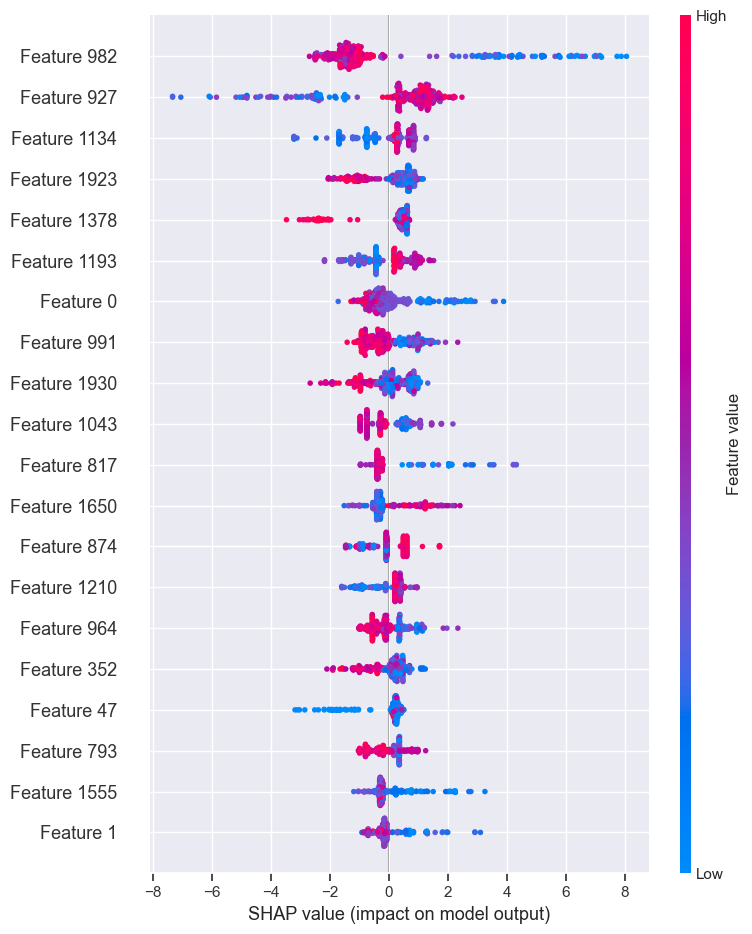

In [ ]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training and testing sets
smoothed_X_train, smoothed_X_test, smoothed_y_train, smoothed_y_test = train_test_split(smoothed_X, y, test_size=0.3, random_state=42)

# Initialize XGBRegressor
smoothed_xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model to training data
smoothed_xgb_reg.fit(smoothed_X_train, smoothed_y_train)

# Predict on the testing data
smoothed_y_pred = smoothed_xgb_reg.predict(smoothed_X_test)

# Create explainer object
smoothed_explainer = shap.Explainer(smoothed_xgb_reg, smoothed_X_train)

# Compute Shapley values
smoothed_shap_values = smoothed_explainer.shap_values(smoothed_X_train)

# Calculate mean squared error
smoothed_mse = mean_squared_error(smoothed_y_test, smoothed_y_pred)
smoothed_xgb_rmse = np.sqrt(smoothed_mse)
print("Root Mean Squared Error:", smoothed_xgb_rmse)

# Shapley summary plot
shap.summary_plot(smoothed_shap_values, smoothed_X_train)

In [ ]:
### GET TOP SHAP VALUES IN A LIST ###

shap_top10_5cv = []

# Calculate mean absolute Shapley values for each feature
mean_abs_shap_values_5cv = np.mean(np.abs(shap_values_5cv), axis=0)

# Sort features based on mean absolute Shapley values
sorted_indices_5cv = np.argsort(mean_abs_shap_values_5cv)[::-1]  # Descending order

# Number of top features to select
num_top_features_5cv = 10

# Get the indices of the most important features
top_feature_indices_5cv = sorted_indices_5cv[:num_top_features_5cv]

for i in top_feature_indices_5cv:
    shap_top10_5cv.append(lib.bands.centers[i])

# Print or use the indices of the most important features
print("Top 10 Shapley bands:", shap_top10_5cv)
print(top_feature_indices_5cv)
#print(top_feature_indices)


Top 10 Shapley bands: [1.0, 1.368, 1.325, 1.157, 0.698, 1.147, 1.192, 1.144, 1.222, 0.999]
[ 650 1018  975  807  348  797  842  794  872  649]


In [ ]:
#sorted_indices_perm_impt

perm_impt_top10_5cv = []

# Get the indices of the most important features
top_perm_impt_indices_5cv = sorted_indices_perm_impt[:num_top_features_5cv]

for i in top_perm_impt_indices_5cv:
    perm_impt_top10_5cv.append(lib.bands.centers[i])

# Print or use the indices of the most important features
print("Top 10 Perm Impt bands:", perm_impt_top10_5cv)
print(top_perm_impt_indices_5cv)
#print(top_feature_indices)



Top 10 Perm Impt bands: [1.0, 1.368, 1.325, 1.157, 0.698, 1.144, 1.222, 1.307, 1.192, 1.277]
[ 650 1018  975  807  348  794  872  957  842  927]


In [ ]:
X_shap_top10 = []

for j,_ in enumerate(X):
    top10 = []
    for i in top_feature_indices_5cv:
        top10.append(X[j,i])
    X_shap_top10.append(top10)

X_shap_top10 = np.array(X_shap_top10)

print(len(X_shap_top10))

460


In [ ]:
X_shap_top10[0]

array([0.03678967, 0.02508251, 0.03133578, 0.03441711, 0.00571548,
       0.03562056, 0.03345625, 0.03612036, 0.034005  , 0.03677286])

In [ ]:
### GET TOP 10 XGB FEATURE IMPORTANCE VALUES IN A LIST ###

xgb_top10_features_5cv = list(xgb_feature_importance_map_5cv.keys())  # These are the top 10 wavelengths.

X_xgb_top10_index = []

for i in xgb_top10_features_5cv:
    X_xgb_top10_index.append(lib.bands.centers.index(i))

X_xgb_top10_index

#xgb_feature_indices_5cv = list(xgb_feature_importance_map_5cv.keys())
#xgb_feature_indices_5cv.index(0.811)
#lib.bands.centers.index(0.811)

[975, 461, 218, 927, 794, 987, 807, 214, 872, 1018]

In [ ]:
# Combine the Shap and XGB indices

combined_top10_index = np.concatenate((top_feature_indices_5cv, X_xgb_top10_index))

print(len(combined_top10_index))
print(combined_top10_index)

20
[ 650 1018  975  807  348  797  842  794  872  649  975  461  218  927
  794  987  807  214  872 1018]


In [ ]:
X_xgb_top10 = []

for j,_ in enumerate(X):
    top10 = []
    for i in X_xgb_top10_index:
        top10.append(X[j,i])
    X_xgb_top10.append(top10)

X_xgb_top10 = np.array(X_xgb_top10)

print(X_xgb_top10[0])

[0.03133578 0.03805231 0.00516819 0.03491764 0.03612036 0.02954046
 0.03441711 0.00560807 0.034005   0.02508251]


In [ ]:
X_top_bands = []

for j,_ in enumerate(X):
    top = []
    for i in combined_top10_index:
        top.append(X[j,i])
    X_top_bands.append(top)

X_top_bands = np.array(X_top_bands)

print(len(X_top_bands))
print(X_top_bands[0])

460
[0.03678967 0.02508251 0.03133578 0.03441711 0.00571548 0.03562056
 0.03345625 0.03612036 0.034005   0.03677286 0.03133578 0.03805231
 0.00516819 0.03491764 0.03612036 0.02954046 0.03441711 0.00560807
 0.034005   0.02508251]


In [ ]:
for i in xgb_feature_indices_5cv:
    print(lib.bands.centers.index(i), ': ',i)

xgb_feature_indices_5cv = list(xgb_feature_importance_map_5cv.keys())
xgb_feature_indices_5cv.index(0.811)
lib.bands.centers.index(0.811)

In [ ]:
### Run lazypredict for water content using only top 10 Shap features ###

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_shap_top10, y,test_size=0.2)  #,random_state =23)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 79%|███████▊  | 33/42 [00:25<00:05,  1.80it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


 95%|█████████▌| 40/42 [00:26<00:00,  2.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3686
[LightGBM] [Info] Number of data points in the train set: 368, number of used features: 30
[LightGBM] [Info] Start training from score 46.524293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

100%|██████████| 42/42 [00:28<00:00,  1.47it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
### Run lazypredict for water content using only top Shap + XGB features ###

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_top_bands, y,test_size=0.2)  #,random_state =23)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 21%|██▏       | 9/42 [00:00<00:02, 14.94it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 79%|███████▊  | 33/42 [00:01<00:00, 23.77it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [00:02<00:00, 15.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2460
[LightGBM] [Info] Number of data points in the train set: 368, number of used features: 20
[LightGBM] [Info] Start training from score 46.585706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
shap_top10 = []

# Calculate mean absolute Shapley values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# Sort features based on mean absolute Shapley values
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]  # Descending order

# Number of top features to select
num_top_features = 10

# Get the indices of the most important features
top_feature_indices = sorted_indices[:num_top_features]

for i in top_feature_indices:
    shap_top10.append(lib.bands.centers[i])

# Print or use the indices of the most important features
print("Top 10 Shapley bands:", shap_top10)
#print(top_feature_indices)


Top 10 Shapley bands: [1.0, 1.159, 2.267, 1.198, 1.3, 1.148, 1.439, 1.15, 1.902, 1.504]


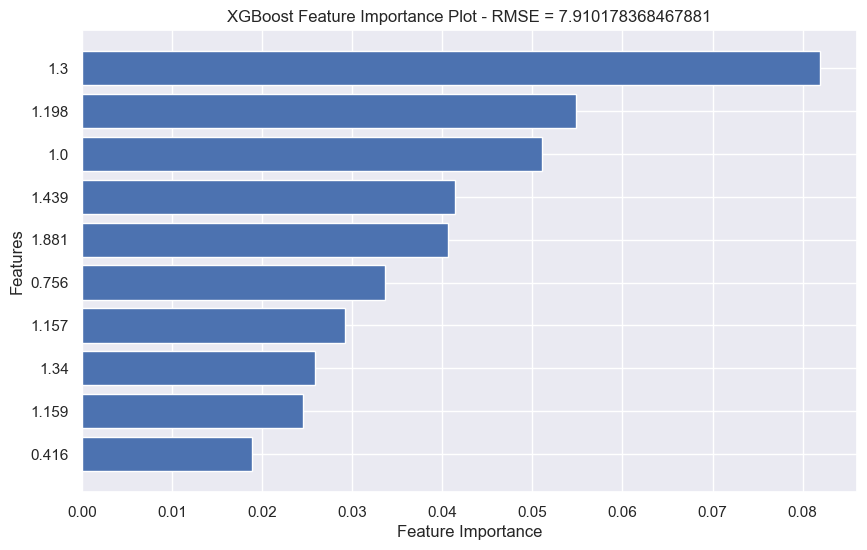

In [ ]:
num_features = 10

# Get feature importances
xgb_feature_importances = xgb_reg.feature_importances_

# Map feature names to importance scores
feature_idx = np.argsort(xgb_feature_importances)[-num_features:]
xgb_feature_importance_map = dict(zip(feature_names[feature_idx], xgb_feature_importances[feature_idx]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(xgb_feature_importance_map)), list(xgb_feature_importance_map.values()), align='center')
plt.yticks(range(len(xgb_feature_importance_map)), list(xgb_feature_importance_map.keys()))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'XGBoost Feature Importance Plot - RMSE = {xgb_rmse}')
plt.show()

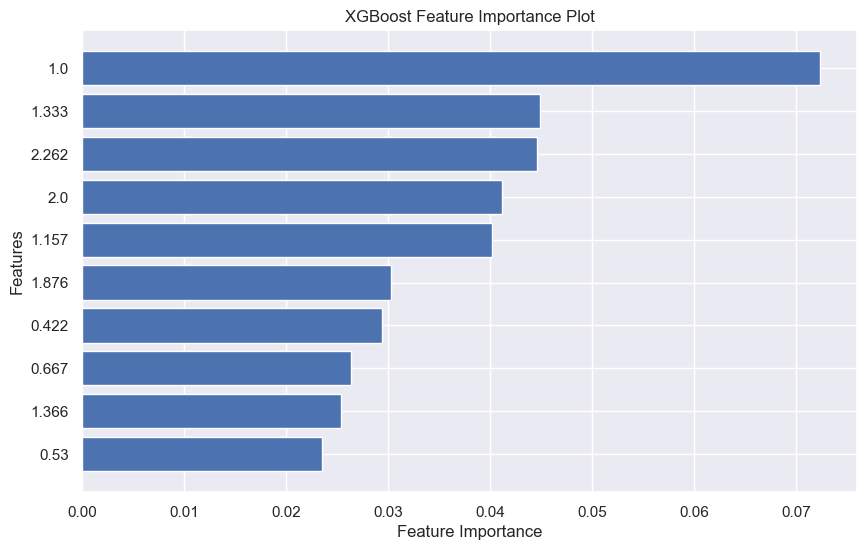

In [ ]:
num_features = 10

# Get feature importances
xgb_feature_importances_5cv = xgb_reg_5cv.feature_importances_

# Map feature names to importance scores
feature_idx = np.argsort(xgb_feature_importances_5cv)[-num_features:]
xgb_feature_importance_map_5cv = dict(zip(feature_names[feature_idx], xgb_feature_importances_5cv[feature_idx]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(xgb_feature_importance_map_5cv)), list(xgb_feature_importance_map_5cv.values()), align='center')
plt.yticks(range(len(xgb_feature_importance_map_5cv)), list(xgb_feature_importance_map_5cv.keys()))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'XGBoost Feature Importance Plot')
#plt.title(f'XGBoost Feature Importance Plot - RMSE = {xgb_rmse_test_5cv}')
plt.show()

In [ ]:
list(xgb_feature_importance_map_5cv.keys())  # These are the top 10 wavelengths.

[1.325, 0.811, 0.568, 1.277, 1.144, 1.337, 1.157, 0.564, 1.222, 1.368]

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize LGBMRegressor
lgb_reg = lgb.LGBMRegressor(random_state=42)

# Fit the model to training data
lgb_reg.fit(X_train, y_train);

# Predict on the testing data
y_pred = lgb_reg.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
lgb_rmse = np.sqrt(mse)
print("Root Mean Squared Error:", lgb_rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232189
[LightGBM] [Info] Number of data points in the train set: 322, number of used features: 2151
[LightGBM] [Info] Start training from score 46.754441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [ ]:
### LGBM WITH 5-FOLD CROSS VALIDATION ###

import lightgbm as lgb

# Initialize LGBMRegressor
lgb_reg_5cv = lgb.LGBMRegressor()

# Fit the model to training data
lgb_reg_5cv.fit(X, y);

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
lgb_cv_scores = cross_val_score(lgb_reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -lgb_cv_scores)
print("Mean squared error across all folds:", -np.mean(lgb_cv_scores))

# Predict on the testing data
y_pred_lgb_5cv = lgb_reg_5cv.predict(X)

# Calculate and print the mean squared error on the test set
lgb_mse_test = mean_squared_error(y, y_pred_lgb_5cv)
lgb_rmse_test = np.sqrt(lgb_mse_test)
print("Mean squared error on test set:", lgb_mse_test)
print("Root Mean Squared Error on Test Set:", lgb_rmse_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331089
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 2151
[LightGBM] [Info] Start training from score 46.728739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

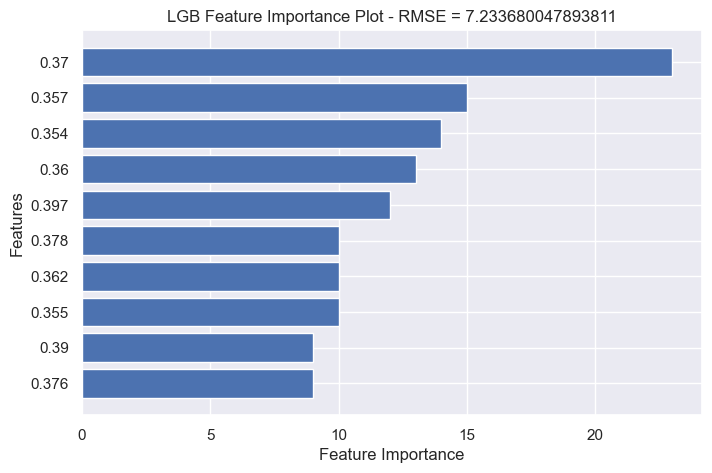

In [ ]:
num_features = 10

# Get feature importances
lgb_feature_importances = lgb_reg.feature_importances_

# Map feature names to importance scores
feature_idx = np.argsort(lgb_feature_importances)[-num_features:]
lgb_feature_importance_map = dict(zip(feature_names[feature_idx], lgb_feature_importances[feature_idx]))

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.barh(range(len(lgb_feature_importance_map)), list(lgb_feature_importance_map.values()), align='center')
plt.yticks(range(len(lgb_feature_importance_map)), list(lgb_feature_importance_map.keys()))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'LGB Feature Importance Plot - RMSE = {lgb_rmse}')
plt.show()

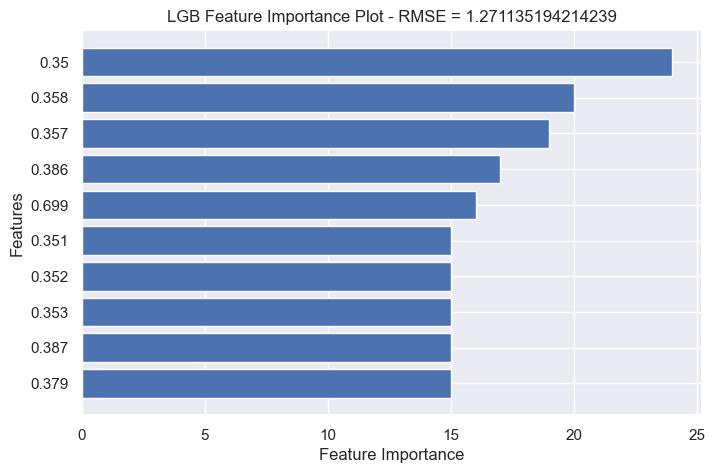

In [ ]:
num_features = 10

# Get feature importances
lgb_feature_importances_5cv = lgb_reg_5cv.feature_importances_

# Map feature names to importance scores
feature_idx = np.argsort(lgb_feature_importances_5cv)[-num_features:]
lgb_feature_importance_map = dict(zip(feature_names[feature_idx], lgb_feature_importances_5cv[feature_idx]))

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.barh(range(len(lgb_feature_importance_map)), list(lgb_feature_importance_map.values()), align='center')
plt.yticks(range(len(lgb_feature_importance_map)), list(lgb_feature_importance_map.keys()))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'LGB Feature Importance Plot - RMSE = {lgb_rmse_test}')
plt.show()

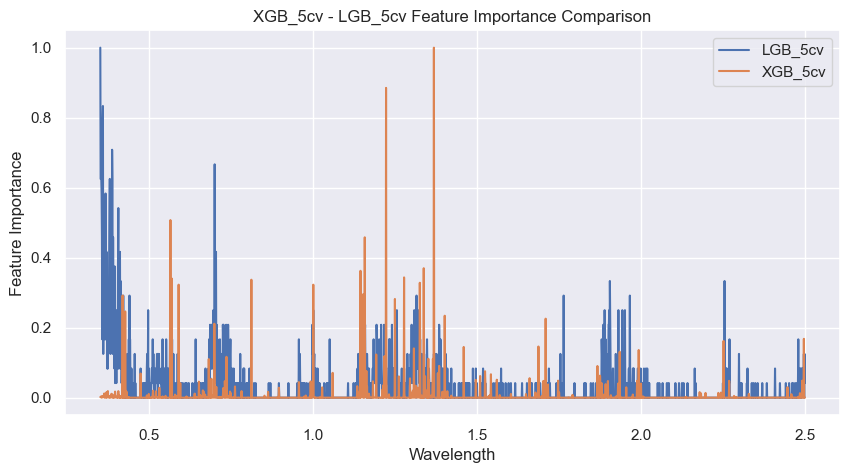

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(feature_names, lgb_feature_importances_5cv/np.max(lgb_feature_importances_5cv), label='LGB_5cv')
plt.plot(feature_names, xgb_feature_importances_5cv/np.max(xgb_feature_importances_5cv), label='XGB_5cv')
#plt.plot(feature_names, shap_top10/np.max(shap_top10))
plt.xlabel('Wavelength')
plt.ylabel('Feature Importance')
plt.title(f'XGB_5cv - LGB_5cv Feature Importance Comparison')
plt.legend()

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Initialize the SVR model
svr = SVR(kernel='rbf', C=5, gamma='scale')  # adjust parameters like kernel, C, and gamma

# Train the SVR model using selected features
svr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svr.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 10.371333988284247


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.svm import LinearSVR  # Import LinearSVR for feature selection
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

# Assuming you have loaded your hyperspectral data into X and corresponding continuous targets into y
# Ensure X is a 2D array where each row represents a flattened hyperspectral image
# Ensure y is a 1D array containing the corresponding continuous target values for each image

# Initialize the LinearSVR model
linear_svr = LinearSVR(random_state=42, dual=True)

# Initialize Recursive Feature Elimination (RFE) with SVR
rfe = RFE(estimator=linear_svr, n_features_to_select=200)  # adjust the number of features to select

# Fit RFE to the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = rfe.support_

# Transform the training and testing sets to contain only the selected features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Initialize the SVR model
svr = SVR(kernel='rbf', C=5.0, gamma='scale')  # adjust parameters like kernel, C, and gamma

# Train the SVR model using selected features
svr.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = svr.predict(X_test_selected)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 10.287974811955262


In [ ]:
results_df = pd.DataFrame(columns=['Regressor', 'MSE', 'RMSE', 'R-Squared'])

Root mean squared error for each fold: [8.05348459 9.91668831 7.73952402 7.88414316 8.62970052]
Root mean squared error across all folds: 8.444708119265368


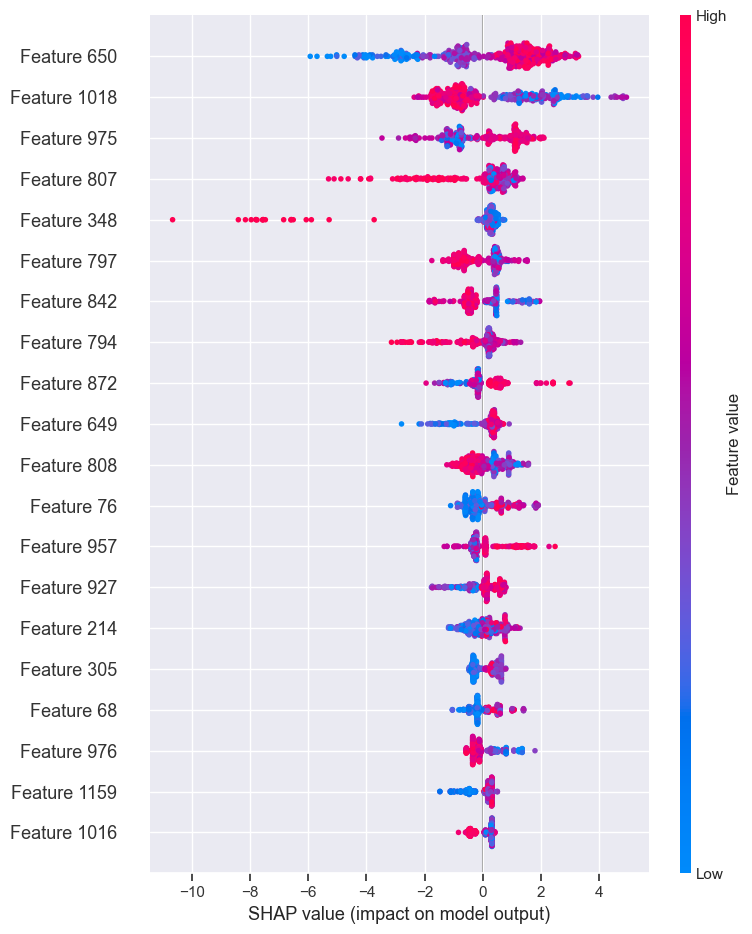

Top 10 Shapley bands: [1.0, 1.368, 1.325, 1.157, 0.698, 1.147, 1.192, 1.144, 1.222, 0.999]
[ 650 1018  975  807  348  797  842  794  872  649]


In [ ]:
### TEMPLATE REGRESSOR WITH 5-FOLD CROSS VALIDATION ###

from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

# Initialize Regressor
reg_name = 'Random Forest, n=10'
reg_5cv = RandomForestRegressor(n_estimators=10)

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
rmse_folds = np.sqrt(-cv_scores)
print("Root mean squared error for each fold:", rmse_folds)
print("Root mean squared error across all folds:", np.mean(rmse_folds))

# Fit the model to training data
reg_5cv.fit(X, y);

# Predict on the testing data
y_pred_5cv = reg_5cv.predict(X)

# Calculate and print the MSE, RMSE, R-Squared on the test set
mse_test = mean_squared_error(y, y_pred_5cv)
rmse_test = np.sqrt(mse_test)
#print("MSE on Test Set:", mse_test)
#print("RMSE on Test Set:", rmse_test)
r_sq_test = r2_score(y, y_pred_5cv)
#print("R-squared on Test Set:", r_sq_test)

# Create a new DataFrame to store the results
results_df = pd.DataFrame({'Regressor': [reg_name],
    'MSE': [-np.mean(cv_scores)],
    'RMSE': [np.mean(rmse_folds)],
    'R-Squared': [r_sq_test]})

# Append results to DataFrame
# results_df = results_df.append(df_append, ignore_index=True)

results_df


# Create explainer object
explainer_5cv = shap.Explainer(xgb_reg_5cv, X)

# Compute Shapley values
shap_values_5cv = explainer_5cv.shap_values(X)

# Shapley summary plot
shap.summary_plot(shap_values_5cv, X)

shap_top10_5cv = []

# Calculate mean absolute Shapley values for each feature
mean_abs_shap_values_5cv = np.mean(np.abs(shap_values_5cv), axis=0)

# Sort features based on mean absolute Shapley values
sorted_indices_5cv = np.argsort(mean_abs_shap_values_5cv)[::-1]  # Descending order

# Number of top features to select
num_top_features_5cv = 10

# Get the indices of the most important features
top_feature_indices_5cv = sorted_indices_5cv[:num_top_features_5cv]

for i in top_feature_indices_5cv:
    shap_top10_5cv.append(lib.bands.centers[i])

# Print or use the indices of the most important features
print("Top 10 Shapley bands:", shap_top10_5cv)
print(top_feature_indices_5cv)
#print(top_feature_indices)


Root mean squared error for each fold: [9.0397336  6.92565758 7.25249656 7.51385519 9.25770455]
Root mean squared error across all folds: 7.997889496258833


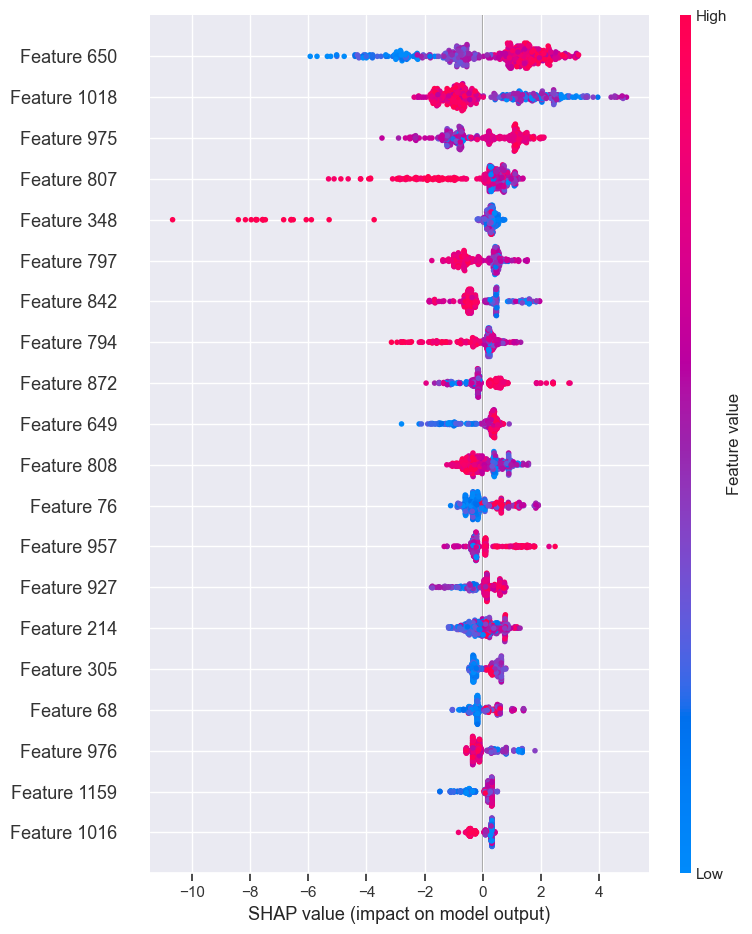

Top 10 Shapley bands: [1.0, 1.368, 1.325, 1.157, 0.698, 1.147, 1.192, 1.144, 1.222, 0.999]
[ 650 1018  975  807  348  797  842  794  872  649]


In [ ]:
### TEMPLATE REGRESSOR WITH 5-FOLD CROSS VALIDATION ###

from sklearn.metrics import r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

# Initialize Regressor
reg_name = 'XGB'
reg_5cv = xgb.XGBRegressor(objective='reg:squarederror')

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
rmse_folds = np.sqrt(-cv_scores)
print("Root mean squared error for each fold:", rmse_folds)
print("Root mean squared error across all folds:", np.mean(rmse_folds))

# Fit the model to training data
reg_5cv.fit(X, y);

# Predict on the testing data
y_pred_5cv = reg_5cv.predict(X)

# Calculate and print the MSE, RMSE, R-Squared on the test set
mse_test = mean_squared_error(y, y_pred_5cv)
rmse_test = np.sqrt(mse_test)
#print("MSE on Test Set:", mse_test)
#print("RMSE on Test Set:", rmse_test)
r_sq_test = r2_score(y, y_pred_5cv)
#print("R-squared on Test Set:", r_sq_test)

# Create a new DataFrame to store the results
results_df = pd.DataFrame({'Regressor': [reg_name],
    'MSE': [-np.mean(cv_scores)],
    'RMSE': [np.mean(rmse_folds)],
    'R-Squared': [r_sq_test]})

# Append results to DataFrame
# results_df = results_df.append(df_append, ignore_index=True)

results_df


# Create explainer object
explainer_5cv = shap.Explainer(xgb_reg_5cv, X)

# Compute Shapley values
shap_values_5cv = explainer_5cv.shap_values(X)

# Shapley summary plot
shap.summary_plot(shap_values_5cv, X)

shap_top10_5cv = []

# Calculate mean absolute Shapley values for each feature
mean_abs_shap_values_5cv = np.mean(np.abs(shap_values_5cv), axis=0)

# Sort features based on mean absolute Shapley values
sorted_indices_5cv = np.argsort(mean_abs_shap_values_5cv)[::-1]  # Descending order

# Number of top features to select
num_top_features_5cv = 10

# Get the indices of the most important features
top_feature_indices_5cv = sorted_indices_5cv[:num_top_features_5cv]

for i in top_feature_indices_5cv:
    shap_top10_5cv.append(lib.bands.centers[i])

# Print or use the indices of the most important features
print("Top 10 Shapley bands:", shap_top10_5cv)
print(top_feature_indices_5cv)
#print(top_feature_indices)


In [ ]:
### TEMPLATE REGRESSOR WITH 5-FOLD CROSS VALIDATION ###

from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Initialize Regressor
reg_name = 'SVR'
reg_5cv = SVR(kernel='rbf', C=5, gamma='scale')

# Fit the model to training data
reg_5cv.fit(X, y);

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
rmse_folds = np.sqrt(-cv_scores)
print("Root mean squared error for each fold:", rmse_folds)
print("Root mean squared error across all folds:", np.mean(rmse_folds))

# Predict on the testing data
y_pred_5cv = reg_5cv.predict(X)

# Calculate and print the MSE, RMSE, R-Squared on the test set
mse_test = mean_squared_error(y, y_pred_5cv)
rmse_test = np.sqrt(mse_test)
#print("MSE on Test Set:", mse_test)
#print("RMSE on Test Set:", rmse_test)
r_sq_test = r2_score(y, y_pred_5cv)
#print("R-squared on Test Set:", r_sq_test)

# Create a new DataFrame to store the results
results_df_hist = pd.DataFrame({'Regressor': [reg_name],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'R-Squared': [r_sq_test]})

# Append results to DataFrame
# results_df = results_df.append(df_append, ignore_index=True)

results_df_hist

Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.


Mean squared error for each fold: [108.86443202 116.90375585 101.04296564 111.48876749  77.45194292]
Mean squared error across all folds: 103.15037278421855


Regressor         MSE       RMSE  R-Squared
0       SVR  100.863395  10.043077   0.114016

In [ ]:
### TEMPLATE REGRESSOR WITH 5-FOLD CROSS VALIDATION on TOP FEATURES ###

from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Initialize Regressor
reg_name = 'HistGradientBoostingRegressor'
reg_5cv = HistGradientBoostingRegressor()

# Fit the model to training data
reg_5cv.fit(X_top_bands, y);

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(reg_5cv, X_top_bands, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -cv_scores)
print("Mean squared error across all folds:", -np.mean(cv_scores))

# Predict on the testing data
y_pred_5cv = reg_5cv.predict(X_top_bands)

# Calculate and print the MSE, RMSE, R-Squared on the test set
mse_test = mean_squared_error(y, y_pred_5cv)
rmse_test = np.sqrt(mse_test)
#print("MSE on Test Set:", mse_test)
#print("RMSE on Test Set:", rmse_test)
r_sq_test = r2_score(y, y_pred_5cv)
#print("R-squared on Test Set:", r_sq_test)

# Create a new DataFrame to store the results
results_df_hist = pd.DataFrame({'Regressor': [reg_name],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'R-Squared': [r_sq_test]})

# Append results to DataFrame
# results_df = results_df.append(df_append, ignore_index=True)

results_df_hist

Mean squared error for each fold: [48.08341823 54.79761251 74.94295621 42.07968144 59.55834766]
Mean squared error across all folds: 55.89240320899246


Regressor  MSE  RMSE  R-Squared
0  HistGradientBoostingRegressor 4.89  2.21       0.96

In [ ]:
# Create new Dataframe to store all results
results_df = pd.DataFrame(columns=['Sensor', 'Substance', 'Model', 'Dataset', 'MSE', 'RMSE', 'R-Squared'])


In [ ]:
### FUNCTION FOR REGRESSOR WITH 5-FOLD CROSS VALIDATION ###

from sklearn.metrics import r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

def run_model(sensor, substance, reg_name, dataset, reg_5cv, X, y):
    
    results_df = pd.DataFrame(columns=['Sensor', 'Substance', 'Model', 'Dataset', 'MSE', 'RMSE', 'R-Squared on Test Sets'])

    # Define the KFold cross-validation object
    kf = KFold(n_splits=5, shuffle=True)

    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

    # Print the mean cross-validation scores
    rmse_folds = np.sqrt(-cv_scores)
    print("Root mean squared error for each fold:", rmse_folds)
    print("Root mean squared error across all folds:", np.mean(rmse_folds))

    # Fit the model to training data
    reg_5cv.fit(X, y);

    # Predict on the testing data
    y_pred_5cv = reg_5cv.predict(X)

    # Calculate and print the MSE, RMSE, R-Squared on the test set
    mse_test = mean_squared_error(y, y_pred_5cv)
    rmse_test = np.sqrt(mse_test)
    #print("MSE on Test Set:", mse_test)
    #print("RMSE on Test Set:", rmse_test)
    r_sq_test = r2_score(y, y_pred_5cv)
    #print("R-squared on Test Set:", r_sq_test)

    # Append results to DataFrame
    results_df = results_df._append({'Sensor': sensor,
        'Substance': substance,
        'Model': reg_name,
        'Dataset': dataset,
        'MSE': -np.mean(cv_scores),
        'RMSE': np.mean(rmse_folds),
        'R-Squared on Test Sets': r_sq_test}, ignore_index=True)

    return(results_df)

In [ ]:
# Create explainer object
explainer_5cv = shap.Explainer(xgb_reg_5cv, X)

# Compute Shapley values
shap_values_5cv = explainer_5cv.shap_values(X)

# Shapley summary plot
shap.summary_plot(shap_values_5cv, X)

shap_top10_5cv = []

# Calculate mean absolute Shapley values for each feature
mean_abs_shap_values_5cv = np.mean(np.abs(shap_values_5cv), axis=0)

# Sort features based on mean absolute Shapley values
sorted_indices_5cv = np.argsort(mean_abs_shap_values_5cv)[::-1]  # Descending order

# Number of top features to select
num_top_features_5cv = 10

# Get the indices of the most important features
top_feature_indices_5cv = sorted_indices_5cv[:num_top_features_5cv]

for i in top_feature_indices_5cv:
    shap_top10_5cv.append(lib.bands.centers[i])

# Print or use the indices of the most important features
print("Top 10 Shapley bands:", shap_top10_5cv)
print(top_feature_indices_5cv)
#print(top_feature_indices)


In [ ]:
run_model('ASD', 'Nitrogen', 'XGB', 'All Data', xgb.XGBRegressor(objective='reg:squarederror'), X_asd_c, y_asd_c)

Root mean squared error for each fold: [3.14032312 3.4706598  4.96008123 4.13181903 4.49504895]
Root mean squared error across all folds: 4.039586428090025


Sensor Substance Model   Dataset        MSE      RMSE  \
0    ASD  Nitrogen   XGB  All Data  16.757382  4.039586   

   R-Squared on Test Sets  
0                     1.0

In [ ]:
run_model('ASD', 'Water', 'RandomForestRegressor', 'Top 20 Bands', RandomForestRegressor(n_estimators=10), X_top_bands)

Root mean squared error for each fold: [7.48079926 8.87608528 7.10727374 8.66923412 9.34439589]
Root mean squared error across all folds: 8.295557660066049


Sensor Substance                  Model       Dataset        MSE      RMSE  \
0    ASD     Water  RandomForestRegressor  Top 20 Bands  69.546788  8.295558   

  R-Squared  R-Squared on Test Sets  
0       NaN                0.899174

In [ ]:
def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

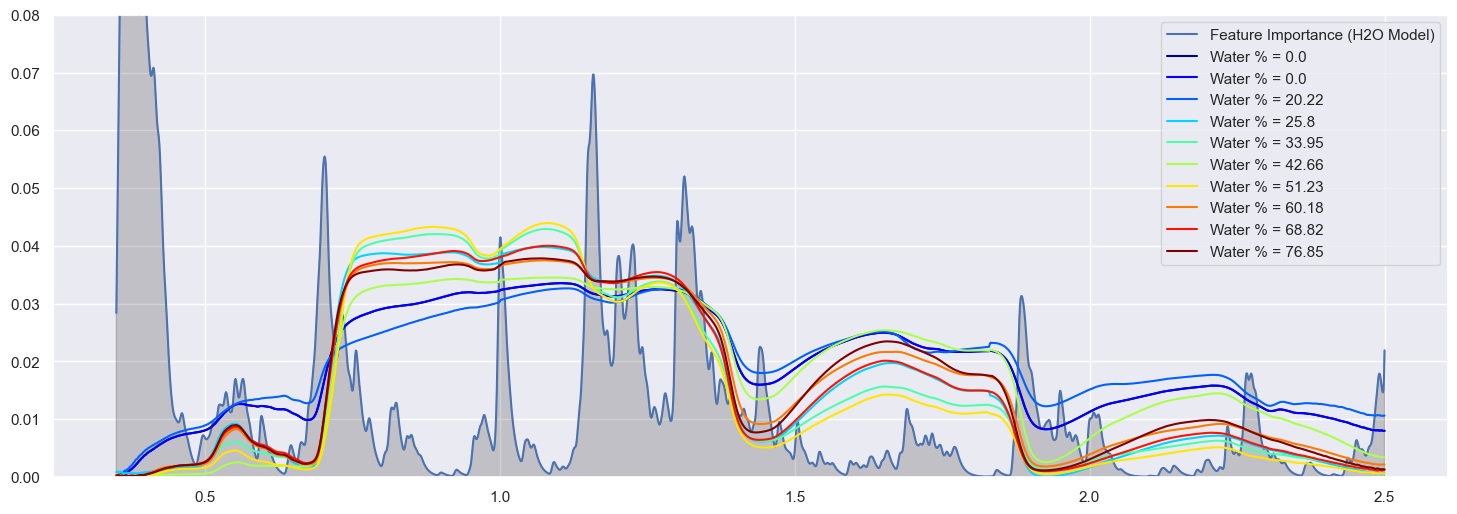

In [ ]:
band_import = lgb_feature_importances/np.max(lgb_feature_importances) + xgb_feature_importances/np.max(xgb_feature_importances)
band_import_smooth = np.zeros(len(band_import))

w = 5
filt = np.zeros(2*w+1)
for i in range(w+1):
    filt[i] = np.exp((-1/9)*(i)**2)
for i in range(len(band_import)):
    s = np.max([0,i-w])
    e = np.min([i+w,len(band_import)])
    sm = 0
    for j in range(s,e):
        band_import_smooth[i] = band_import_smooth[i] + filt[np.abs(i-j)]*band_import[j]
        sm = sm + filt[np.abs(i-j)]
    band_import_smooth[i] = band_import_smooth[i]/sm

    
# Why is this done twice?

band_import = band_import_smooth
w = 5
filt = np.zeros(2*w+1)
for i in range(w+1):
    filt[i] = np.exp((-1/9)*(i)**2)
for i in range(len(band_import)):
    s = np.max([0,i-w])
    e = np.min([i+w,len(band_import)])
    sm = 0
    for j in range(s,e):
        band_import_smooth[i] = band_import_smooth[i] + filt[np.abs(i-j)]*band_import[j]
        sm = sm + filt[np.abs(i-j)]
    band_import_smooth[i] = band_import_smooth[i]/sm
    

plt.figure(figsize=(18,6))
plt.plot(feature_names, band_import_smooth/np.linalg.norm(band_import_smooth), label='Feature Importance (H2O Model)');
plt.fill_between(feature_names,band_import_smooth/np.linalg.norm(band_import_smooth), color='k', alpha=0.2)
for i,c in zip(idx,colors):
    plt.plot(feature_names,X[i,:], label=f'Water % = {y[i]}', c=c)
plt.ylim([0,0.08]);
plt.legend();

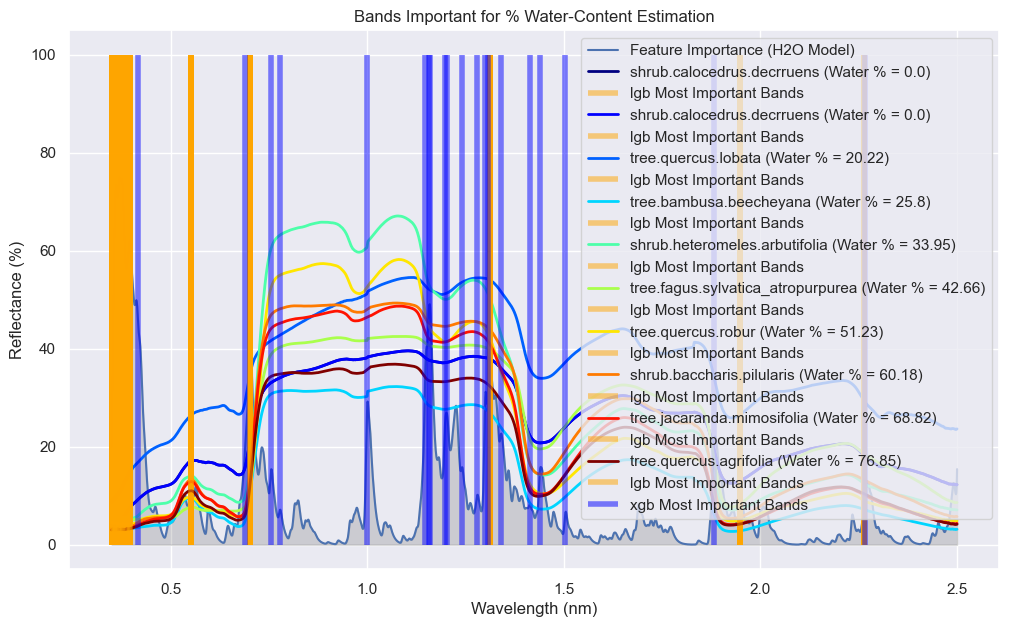

In [ ]:
lgb_feature_importances_normalized = lgb_feature_importances/np.max(lgb_feature_importances)
xgb_feature_importances_normalized =  xgb_feature_importances/np.max(xgb_feature_importances)
lgb_top_10 = feature_names[np.argsort(-lgb_feature_importances_normalized)[:20]]
xgb_top_10 = feature_names[np.argsort(-xgb_feature_importances_normalized)[:20]]

plt.figure()
plt.plot(feature_names, 75*band_import_smooth/np.max(band_import_smooth), label='Feature Importance (H2O Model)');
plt.fill_between(feature_names,75*band_import_smooth/np.max(band_import_smooth), color='k', alpha=0.15)
for i,c in zip(idx,colors):
    veg_name = lib.names[i][1+findOccurrences(lib.names[i], '.')[0]:findOccurrences(lib.names[i], '.')[3]]
    plt.plot(feature_names,X1[i,:], label=veg_name+f' (Water % = {y[i]})', c=c, linewidth=2)

    plt.vlines(lgb_top_10, ymin=0, ymax=100, color='orange', linewidth=4, alpha=0.5, label='lgb Most Important Bands')
plt.vlines(xgb_top_10, ymin=0, ymax=100, color='blue', linewidth=4, alpha=0.5, label='xgb Most Important Bands')
plt.legend();
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%)')
plt.title('Bands Important for % Water-Content Estimation');

In [ ]:
band_import_smooth

array([0.30328591, 0.40302747, 0.50281458, ..., 0.15942326, 0.17840299,
       0.23408921])

In [ ]:
len(data)

1040

In [ ]:
type(data)

dict

In [ ]:
### GENETIC ALGORITM (GA) ###

import numpy as np
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Define the fitness function
def fitness_function(selected_bands, data, labels):

    # Select only the data for the selected bands
    selected_data = data[:, selected_bands]

    # Create a classifier
    #knn = KNeighborsClassifier(n_neighbors=10)

    # Calculate cross-validated accuracy
    #scores = cross_val_score(knn, selected_data, labels, cv=5)
    scores = cross_val_score(xgb_reg, selected_data, labels, cv=5)
    accuracy = np.mean(scores)

    return accuracy

# Genetic Algorithm
def genetic_algorithm(data, labels, pop_size=20, generations=50, mutation_rate=0.1):
    num_bands = data.shape[1]
    pop = np.random.choice([0, 1], size=(pop_size, num_bands), replace=True)
    
    for gen in range(generations):
        # Evaluate fitness
        fitness_scores = np.array([fitness_function(selected_bands, data, labels) for selected_bands in pop])

        # Selection
        selected_indices = np.argsort(fitness_scores)[-int(pop_size/2):]
        selected_pop = pop[selected_indices]

        # Crossover
        new_pop = []
        for _ in range(pop_size - len(selected_pop)):
            #flattened_selected_pop = selected_pop.flatten()  # or selected_pop.reshape(-1)
            #parent1, parent2 = np.random.choice(flattened_selected_pop, size=2, replace=False)
            parent1, parent2 = np.random.choice(selected_pop, size=2, replace=False)
            crossover_point = np.random.randint(num_bands)
            child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            new_pop.append(child)

        # Mutation
        for i in range(len(new_pop)):
            if np.random.rand() < mutation_rate:
                mutation_point = np.random.randint(num_bands)
                new_pop[i][mutation_point] = 1 - new_pop[i][mutation_point]

        pop = np.array(new_pop)

    # Select the best solution
    best_solution_index = np.argmax(fitness_scores)
    best_solution = pop[best_solution_index]

    return best_solution

# Example usage
if __name__ == "__main__":
    # Generate some sample data
    num_samples = 1000
    num_bands = 20
    num_classes = 2
    data = np.random.rand(num_samples, num_bands)
    labels = np.random.randint(num_classes, size=num_samples)

    # Run genetic algorithm
    selected_bands = genetic_algorithm(data, labels)

    print("Selected bands:", selected_bands)


IndexError: invalid index to scalar variable.

In [ ]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/c8/02/d3adf4b4851d99a31c5a9cf7b668f171e84334945d05fb7b51c42bf41abf/torch-2.2.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/81/54/84d42a0bee35edba99dee7b59a8d4970eccdd44b99fe728ed912106fc781/filelock-3.13.1-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/b7/f4/6a90020cd2d93349b442bfcb657d0dc91eee65491600b2cb1d388bc98e6b/typing_extensions-4.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for sympy from https://files.pythonhosted.org/packages/d2/05/e6600db80270777c4a64238a98d442f0fd07cc8915be2a1c16da7f2b9e74/sympy-1.12-py3-none-any.whl.metadata
  Obtaining dependency information for nvidia-cuda-nvrtc-cu12==12.1.105 from https://fil

In [ ]:
import torch

# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
### SEQUENTIAL FORWARD SELECTION (SFS) WITH XGB ###

import numpy as np
from sklearn.model_selection import cross_val_score
#from sklearn.neighbors import KNeighborsClassifier

def fitness_function(selected_bands, data, labels):
    # Use a simple classifier, e.g., k-Nearest Neighbors
    #knn = KNeighborsClassifier(n_neighbors=3)
    selected_data = data[:, selected_bands]
    scores = cross_val_score(xgb_reg, selected_data, labels, cv=5)
    accuracy = np.mean(scores)
    return accuracy

def sequential_forward_selection(data, labels, num_selected_features):
    num_bands = data.shape[1]
    selected_features = []
    remaining_features = list(range(num_bands))

    for _ in range(num_selected_features):
        best_accuracy = -1
        best_feature = None

        for feature in remaining_features:
            current_selection = selected_features + [feature]
            accuracy = fitness_function(current_selection, data, labels)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)

    return selected_features

if __name__ == "__main__":

    # Run Sequential Forward Selection
    num_selected_features = 10
    selected_bands = sequential_forward_selection(X_train, y_train, num_selected_features)

    print("Selected bands:", selected_bands)


KeyboardInterrupt: 

In [ ]:
### SEQUENTIAL FORWARD SELECTION (SFS) WITH KNN ###

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

def fitness_function(selected_bands, data, labels):
    # Use a simple classifier, e.g., k-Nearest Neighbors
    knn = KNeighborsClassifier(n_neighbors=3)
    selected_data = data[:, selected_bands]
    scores = cross_val_score(knn, selected_data, labels, cv=5)
    accuracy = np.mean(scores)
    return accuracy

def sequential_forward_selection(data, labels, num_selected_features):
    num_bands = data.shape[1]
    selected_features = []
    remaining_features = list(range(num_bands))

    for _ in range(num_selected_features):
        best_accuracy = -1
        best_feature = None

        for feature in remaining_features:
            current_selection = selected_features + [feature]
            accuracy = fitness_function(current_selection, data, labels)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)

    return selected_features

# Example usage
if __name__ == "__main__":
    # Generate some sample data
    num_samples = 1000
    num_bands = 20
    num_classes = 2
    sfs_data = np.random.rand(num_samples, num_bands)
    labels = np.random.randint(num_classes, size=num_samples)

    # Run Sequential Forward Selection
    num_selected_features = 5
    selected_bands = sequential_forward_selection(sfs_data, labels, num_selected_features)

    print("Selected bands:", selected_bands)


In [ ]:
X_train.shape